In [1]:
%load_ext autoreload
%autoreload 2

# If you are not in docker, tell the interpreter where to find src. This can be done by
import sys

sys.path.append("../../")
# or
# sys.path.append("/home/username/huawei_cfn/src")

In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
import json
import time
import pandas as pd
from tqdm import tqdm

from utils import get_graphtool_graph
import graph_tool as gt

from load_data import (
    read_graph_sndlib_xml,
    read_traffic_mat_sndlib_xml,
    scale_graph_bandwidth_and_cost,
)

from throughput import solve_throughput

import matplotlib.pyplot as plt

from collections import defaultdict

from main import vanilla_switching, regularized_gd, bounded_ugd, no_potentials_switching, robust_switching, bounded_robust_gd, budget_switching

plt.rcParams.update({"font.size": 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

## Read data

In [3]:
filename = "abilene.xml"
graph = read_graph_sndlib_xml(filename)
graph = scale_graph_bandwidth_and_cost(graph)
traffic_mat = read_traffic_mat_sndlib_xml(filename)
traffic_mat /= traffic_mat.max()

gt_graph = get_graphtool_graph(graph)

A = nx.incidence_matrix(graph, oriented=True).todense()

num_nodes, num_edges = gt_graph.num_vertices(), gt_graph.num_edges()
bandwidths = gt_graph.edge_properties["bandwidths"]

/tmp/ipykernel_322023/759151300.py:9: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(graph, oriented=True).todense()


0.709130259210188


/home/demyan/reps/optima_path_based/utils.py:40: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)


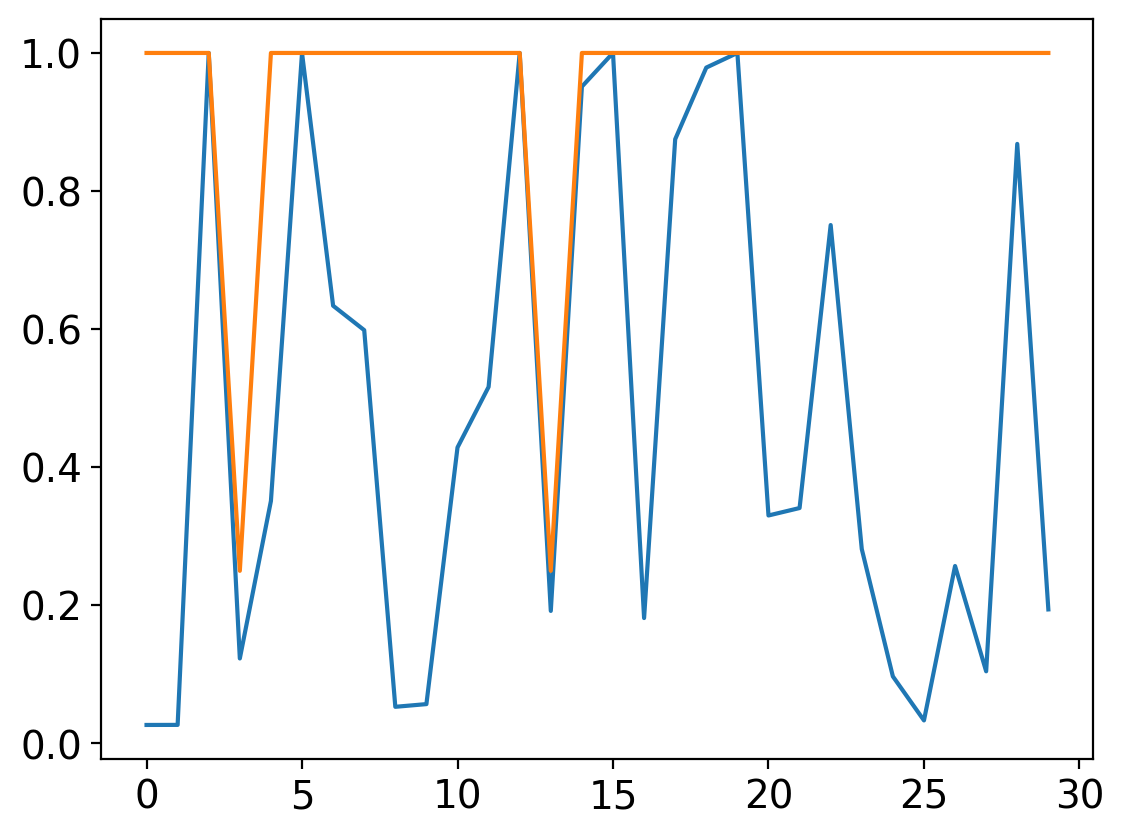

In [4]:
solution = solve_throughput(graph, traffic_mat, solver=cp.SCIPY)
lam, flows_ei = solution.gamma, solution.flow
print(lam)
plt.plot(flows_ei.sum(axis=1))
plt.plot(bandwidths.a)

## Vanilla

In [5]:
lambda_averaged, flows_averaged, lam_delta = vanilla_switching(
    graph,
    traffic_mat,
    max_iters=10000,
    h_f=1e3,  # how large it can be??
    h_g=1e3,
    epsilon=1e-2,
    throughput=lam,
    verbose=False,
)


100%|██████████| 10000/10000 [00:17<00:00, 578.08it/s]


In [6]:
lam_delta = [float(i) for i in lam_delta]

data = {"switching": lam_delta}

df = pd.DataFrame(data)

print(df.head())

   switching
0    1.29087
1    1.29087
2    1.29087
3    1.29087
4    2.29087


## Regularization

/home/demyan/reps/optima_path_based/utils.py:40: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
  0%|          | 0/10000 [00:00<?, ?it/s]

2000.0


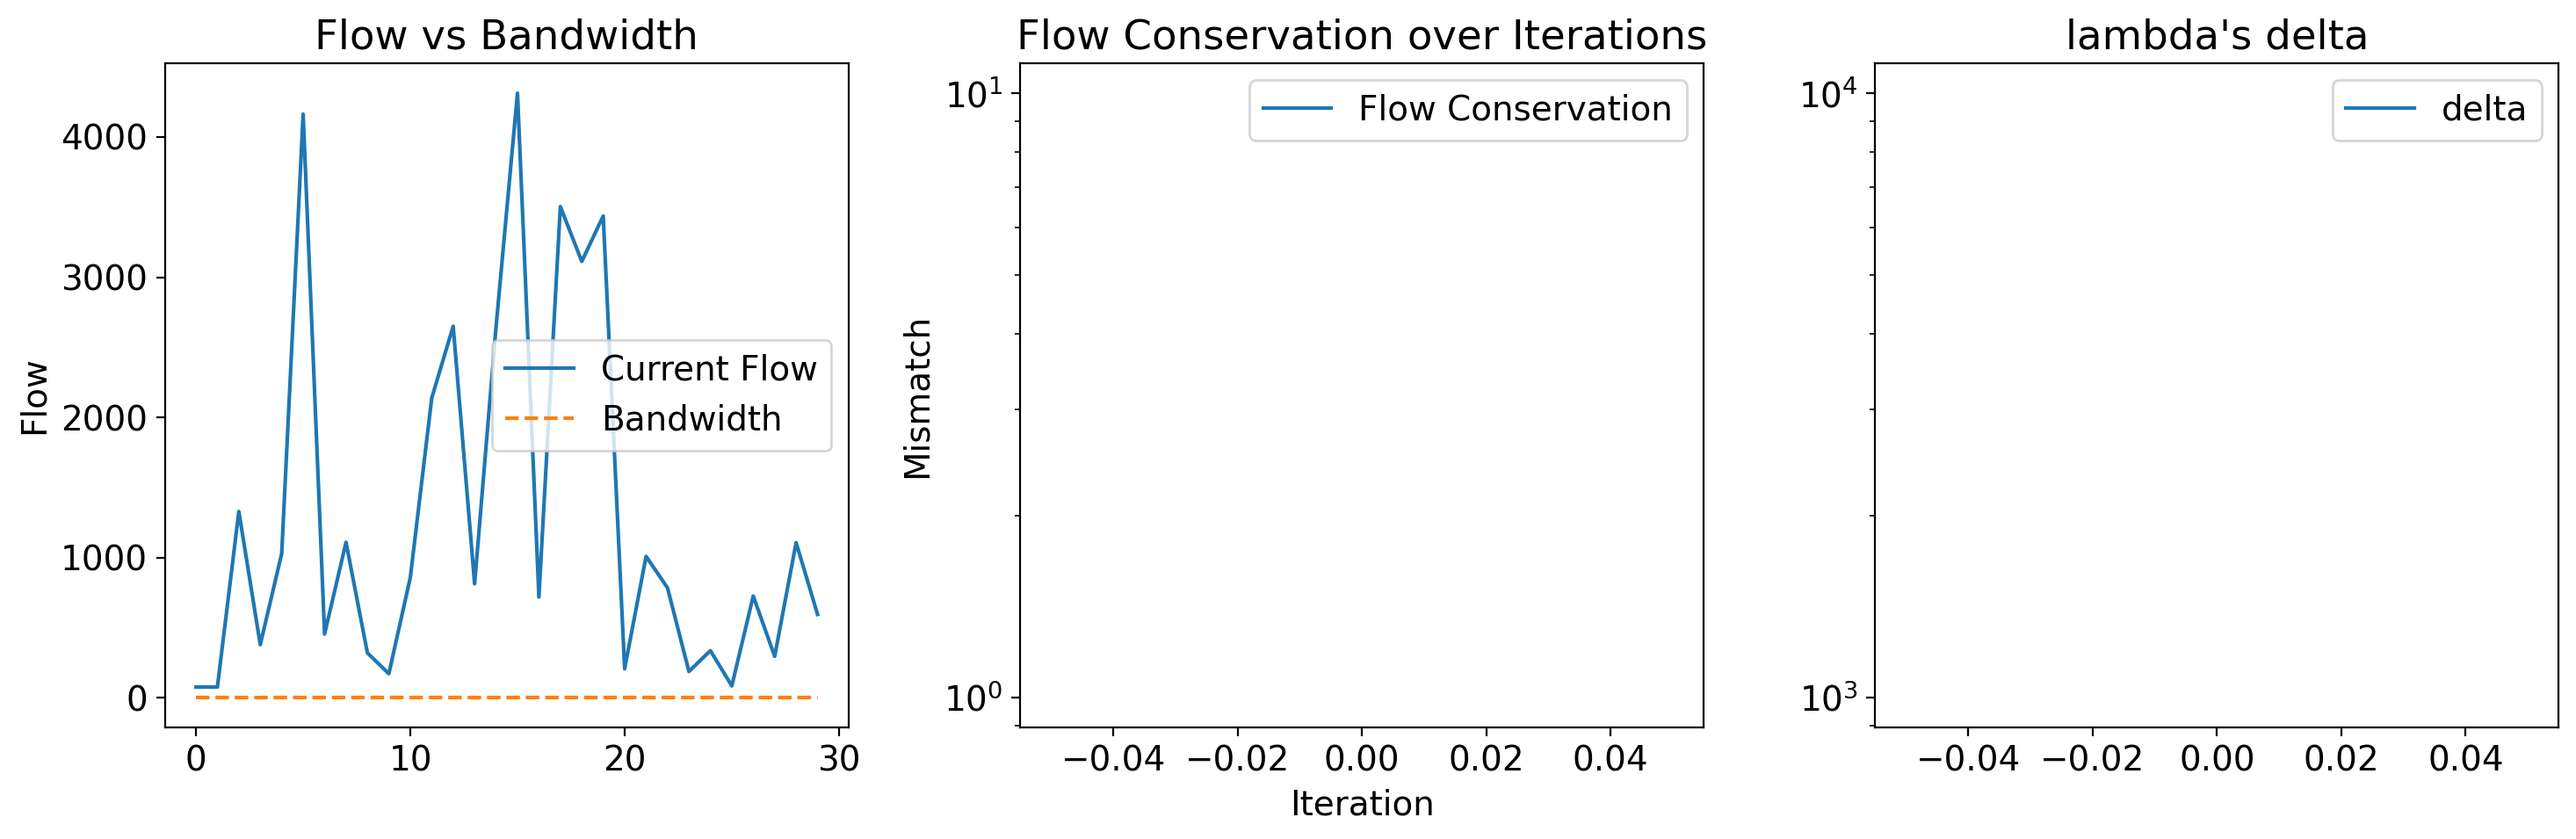

 20%|█▉        | 1975/10000 [00:05<00:18, 445.59it/s]

0.9995002498750625


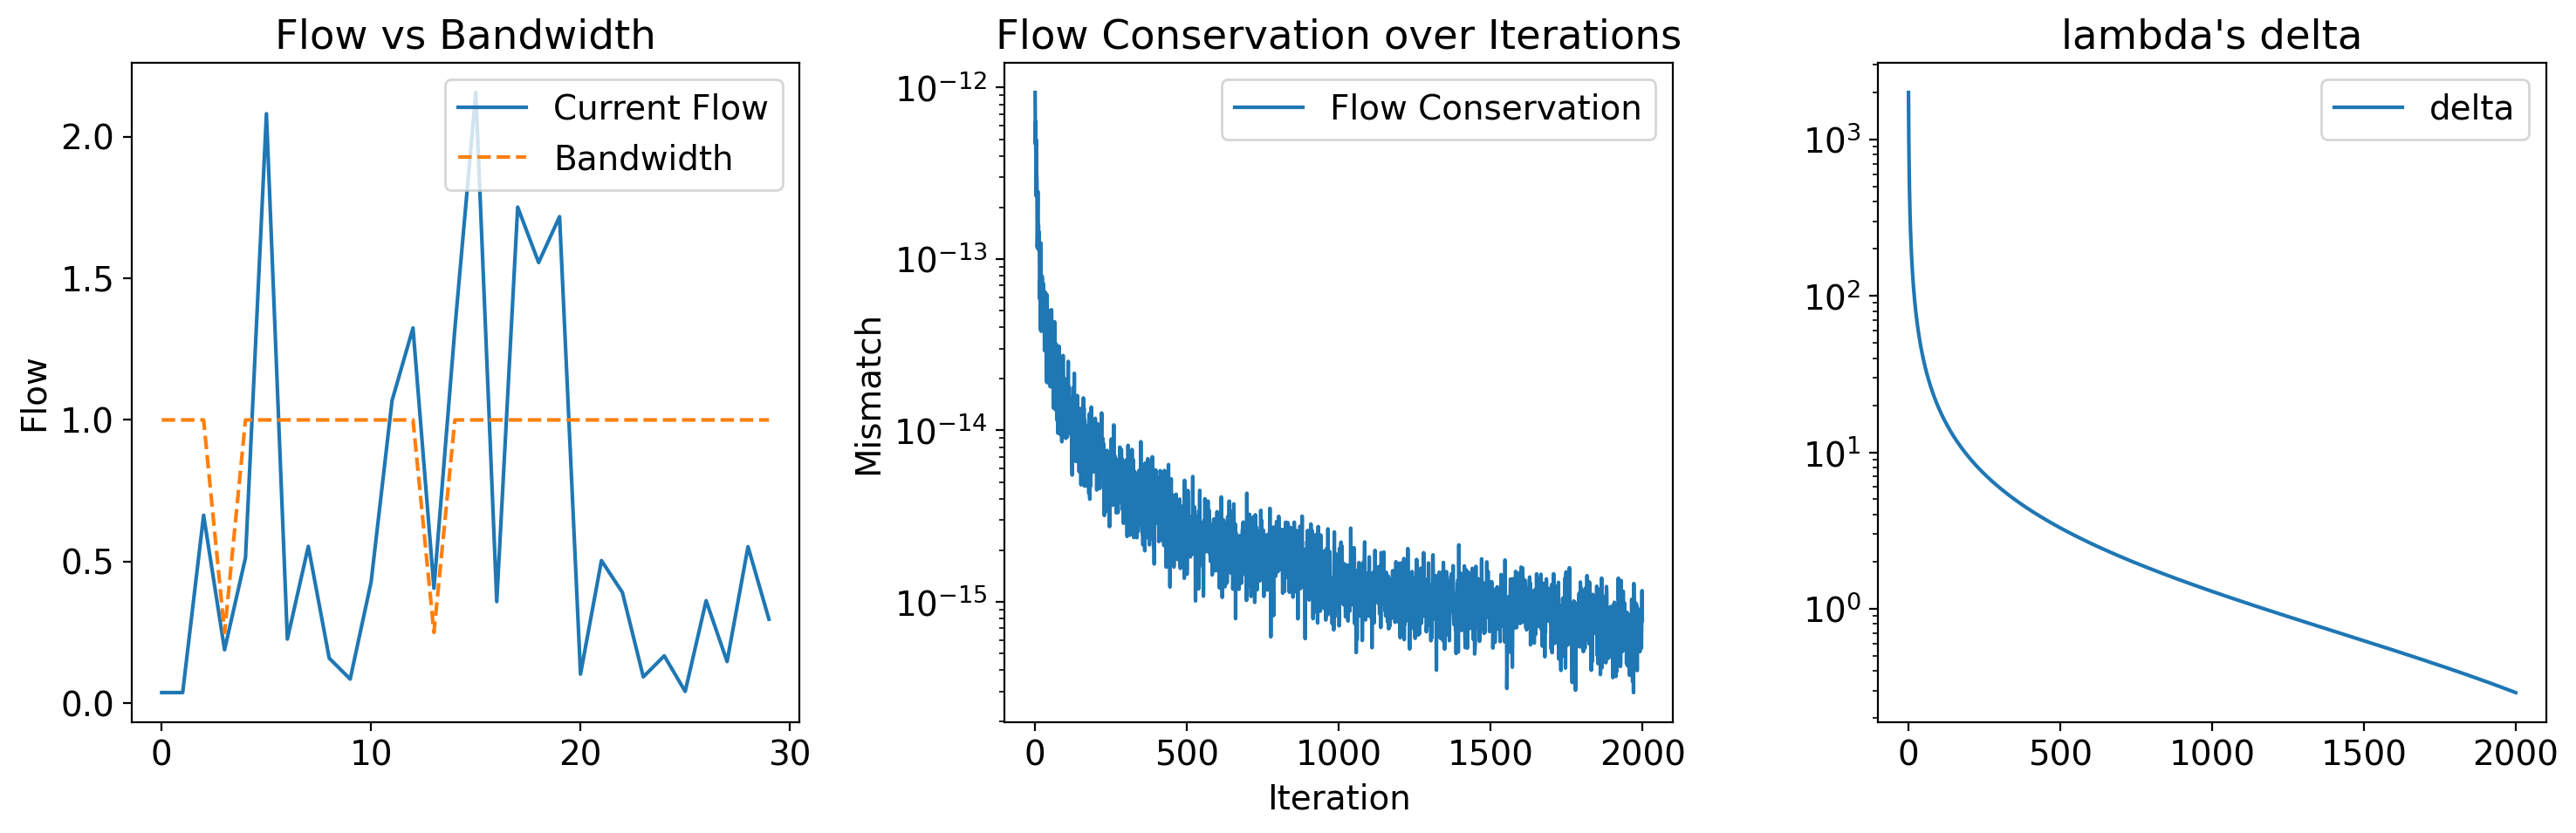

 40%|███▉      | 3951/10000 [00:11<00:08, 699.40it/s]

0.6037125067279556


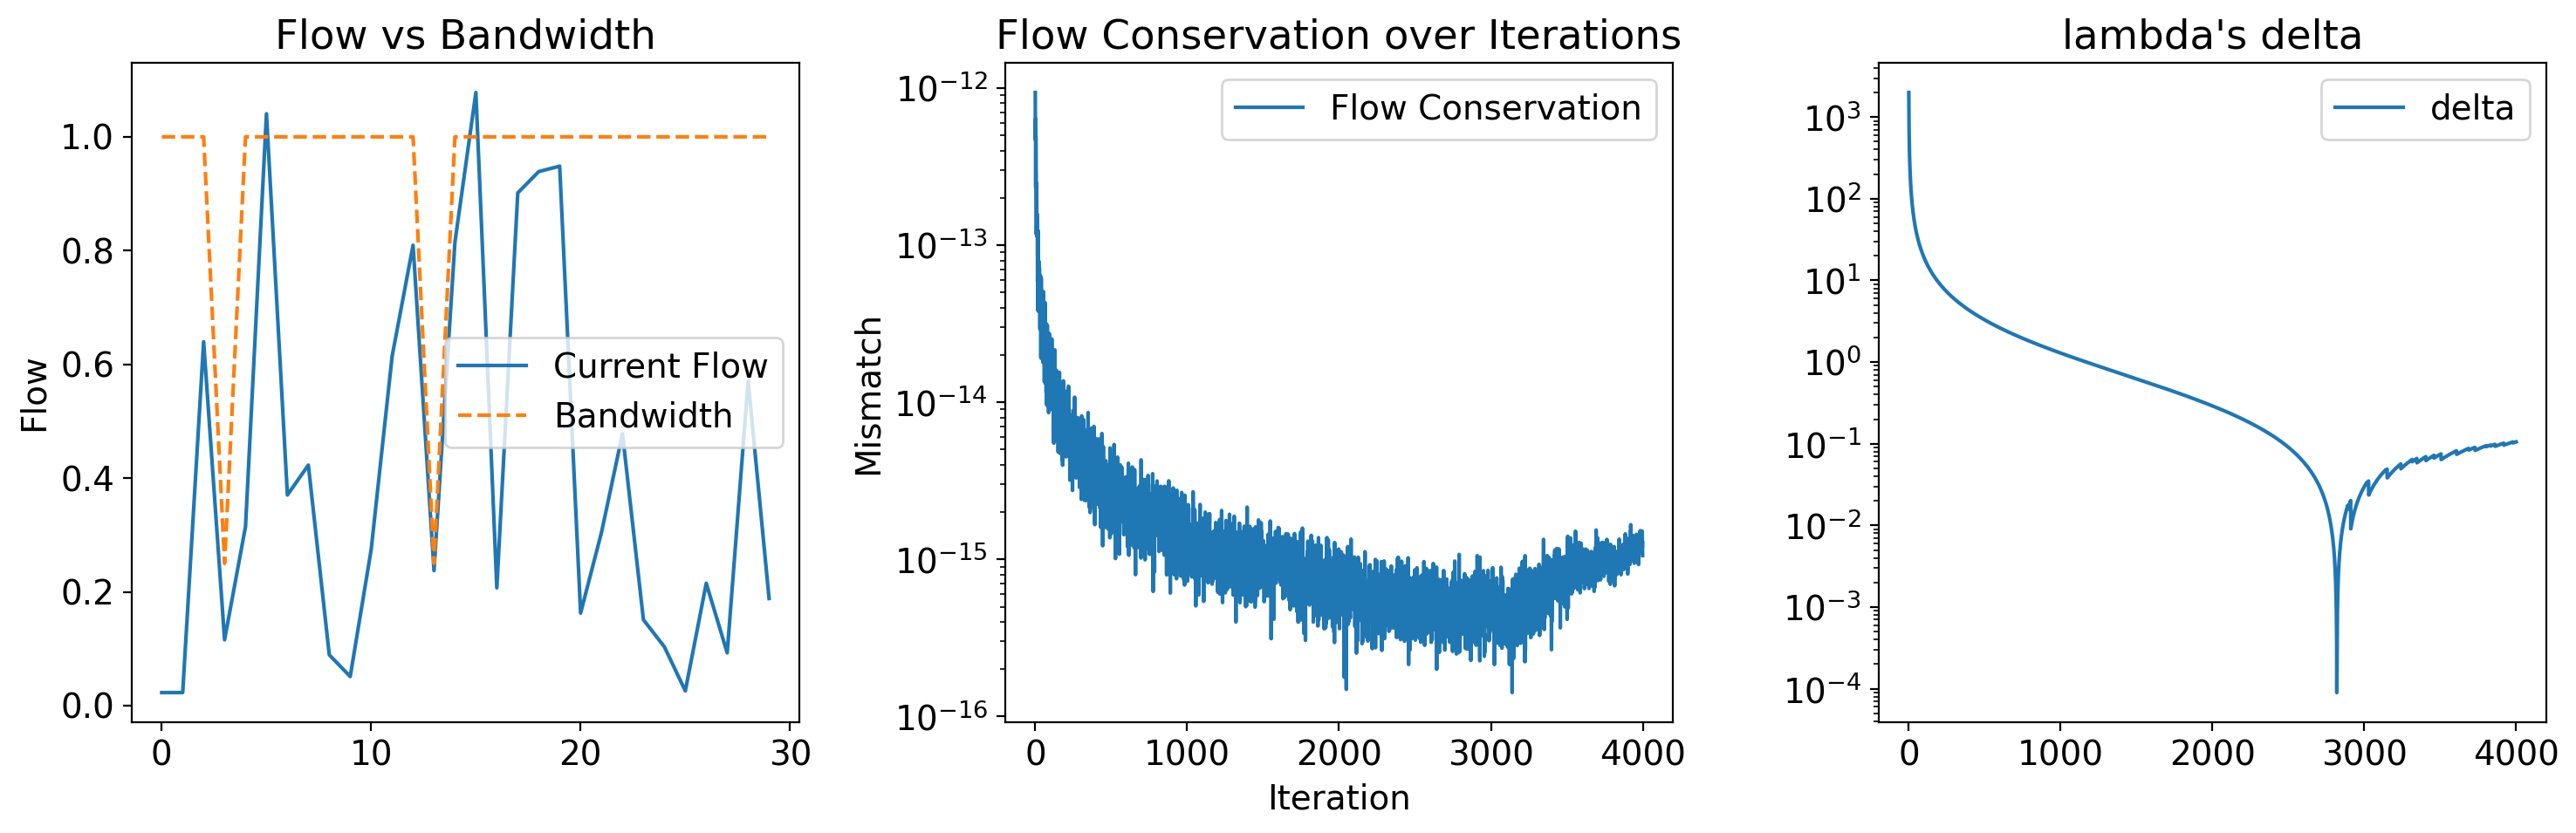

 60%|█████▉    | 5957/10000 [00:14<00:05, 728.33it/s]

0.6360894447004921


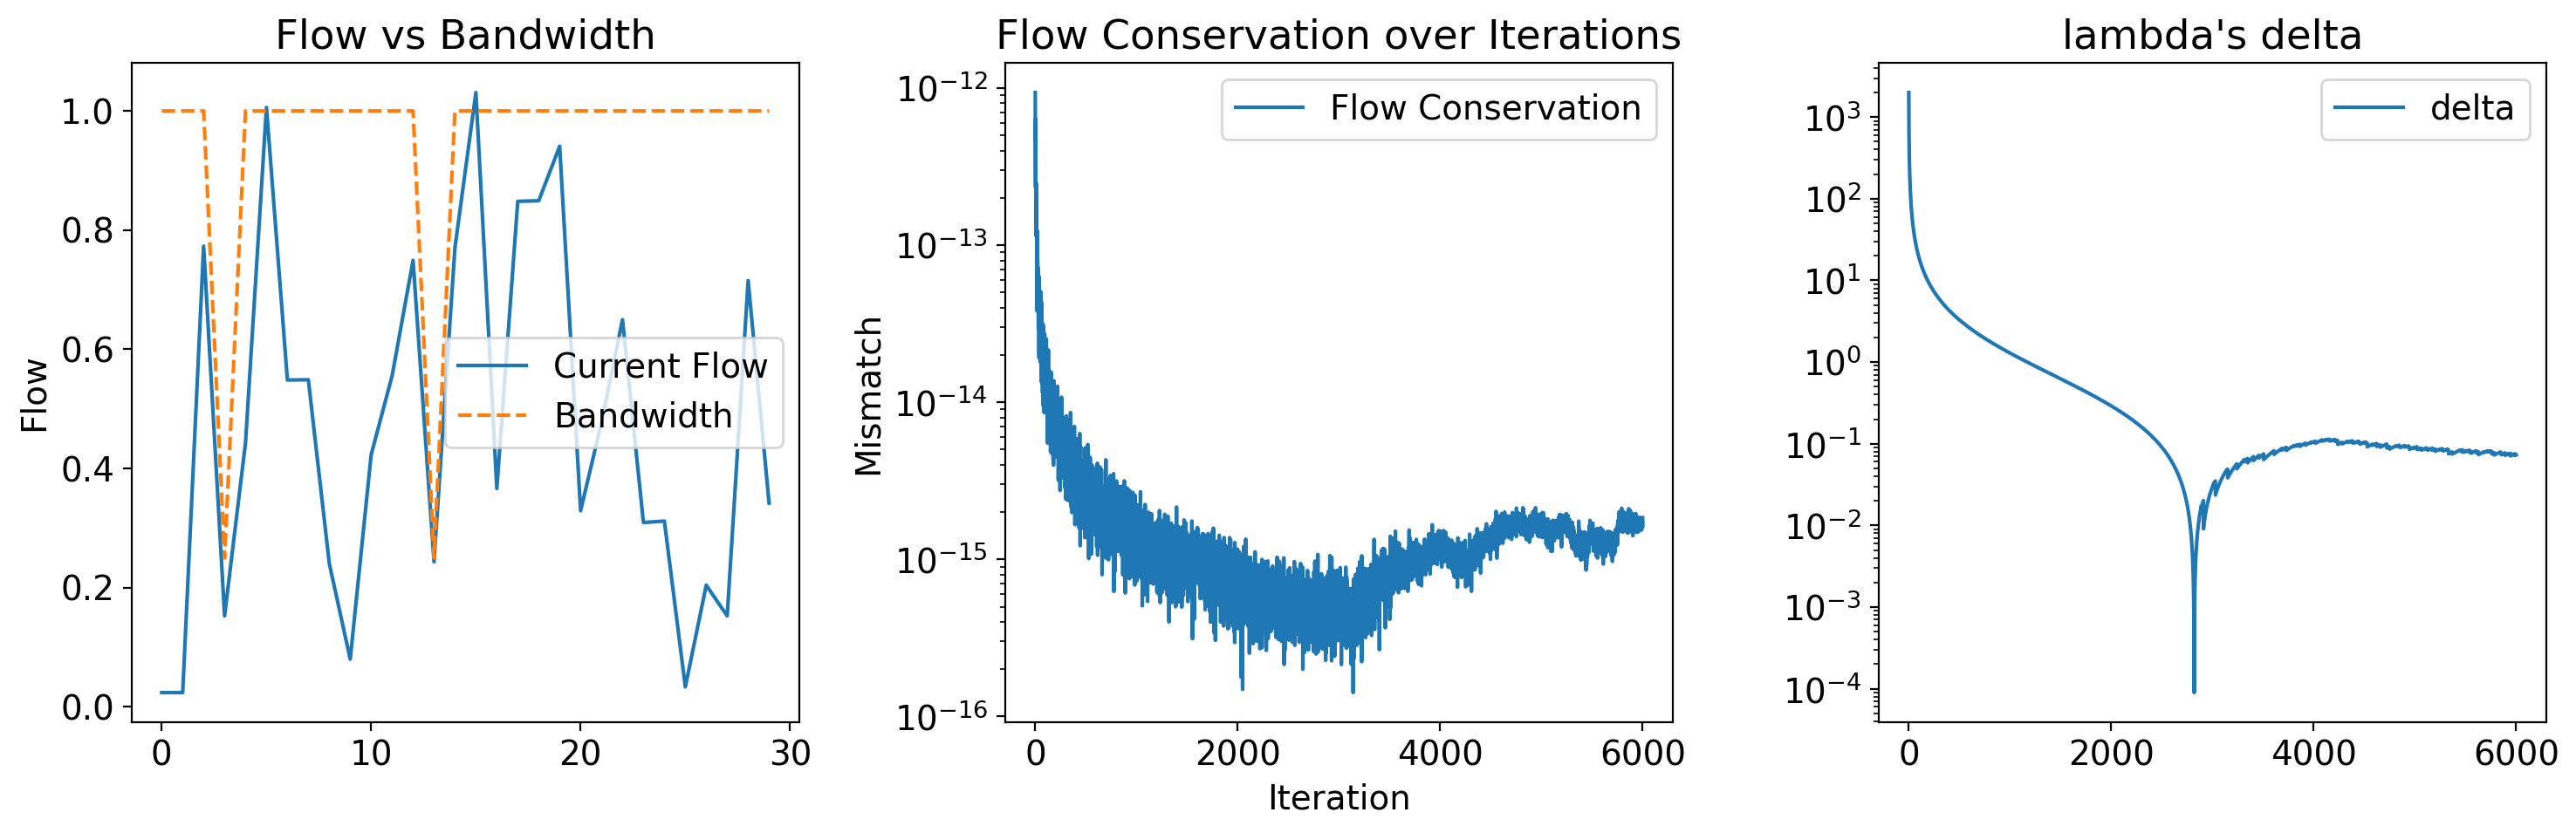

 80%|███████▉  | 7982/10000 [00:18<00:02, 698.02it/s]

0.6553431408043957


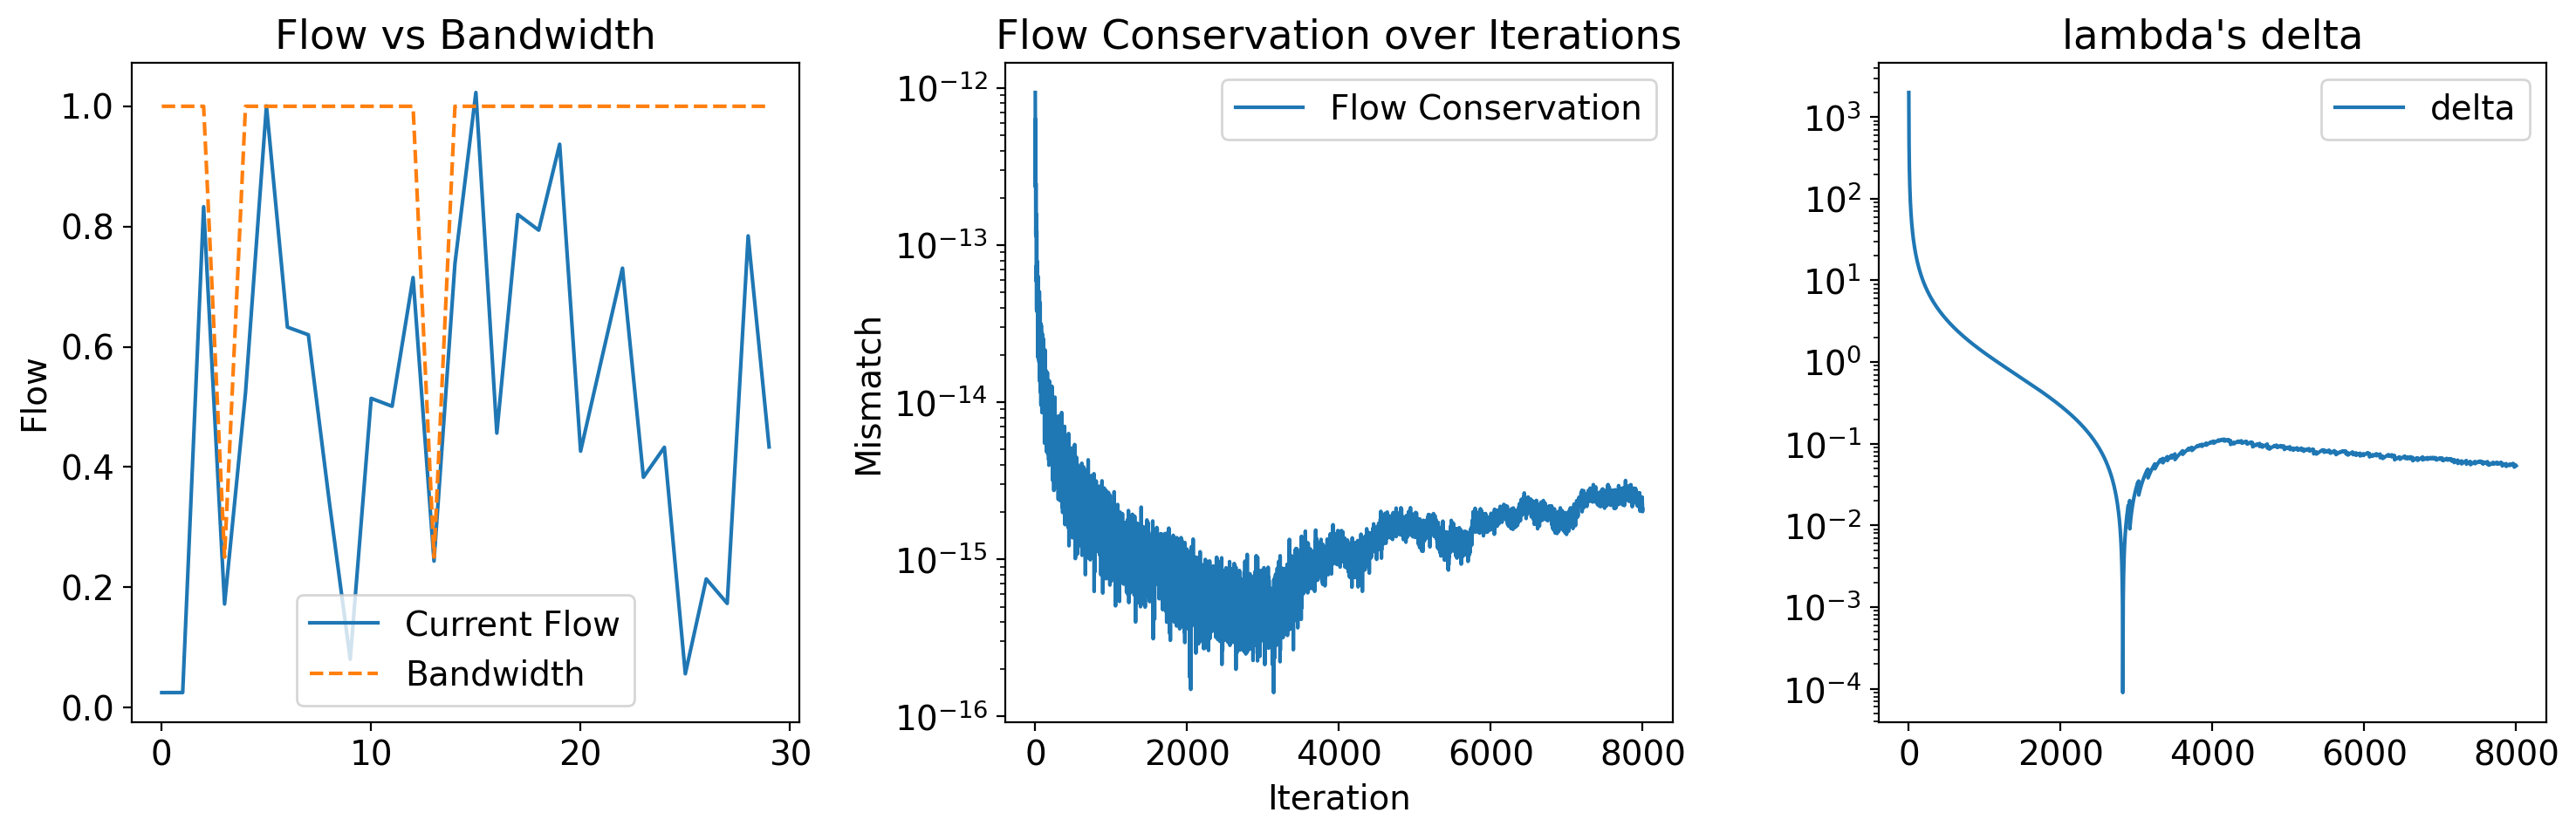

100%|██████████| 10000/10000 [00:22<00:00, 440.58it/s]


In [7]:
lambda_averaged, flows_averaged, lam_delta = regularized_gd(
    graph,
    traffic_mat,
    max_iters=10000,
    h=2e-3, 
    mu=5e-4,
    throughput=lam,
    verbose=True,
)


In [8]:
df["regularization"] = np.nan

lam_delta = [float(i) for i in lam_delta]

for i, value in enumerate(lam_delta):
    df.at[i, "regularization"] = value

print(df.head())

   switching  regularization
0    1.29087     1999.290870
1    1.29087      999.290870
2    1.29087      665.957536
3    1.29087      499.290870
4    2.29087      399.290870


## No potentials

/home/demyan/reps/optima_path_based/utils.py:40: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
  0%|          | 0/10000 [00:00<?, ?it/s]

0.0


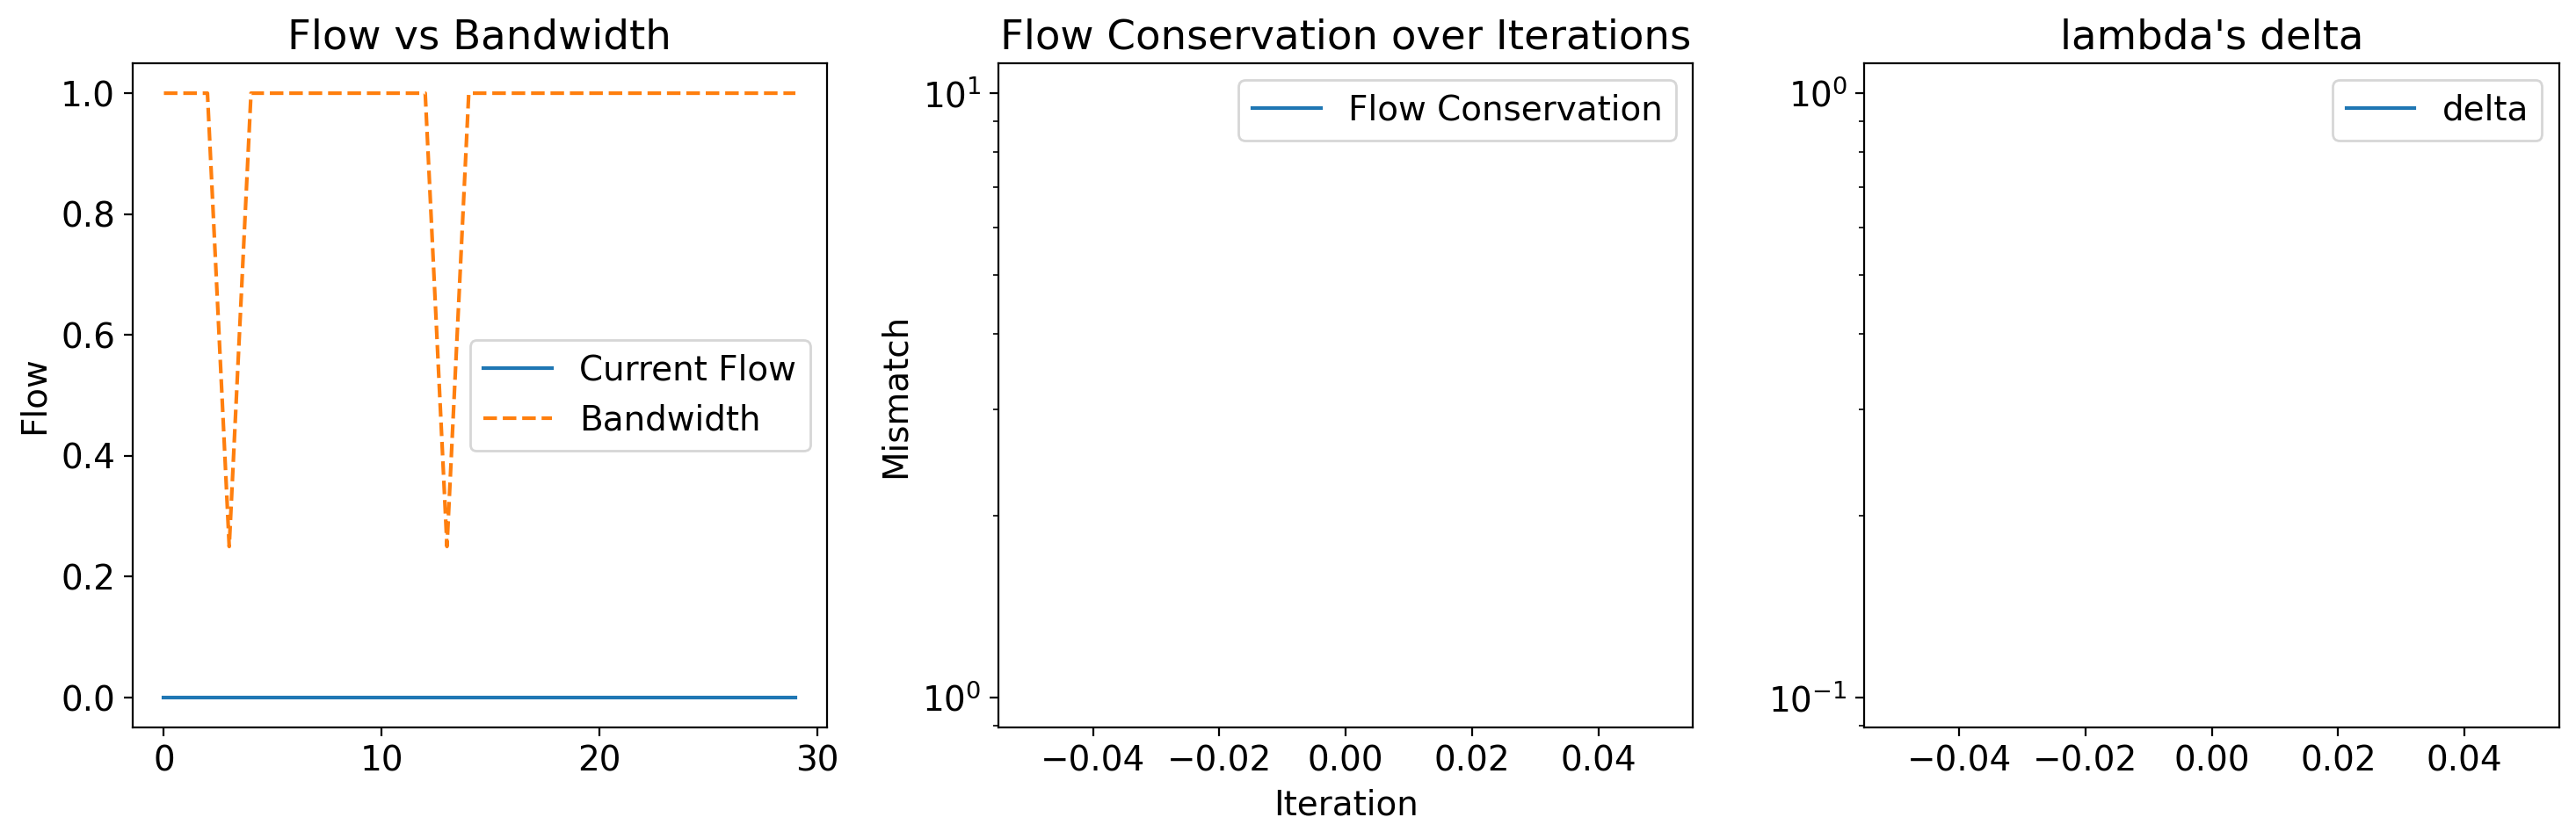

 20%|█▉        | 1967/10000 [00:03<00:12, 628.03it/s]/home/demyan/reps/optima_path_based/utils.py:171: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


0.698641765704584


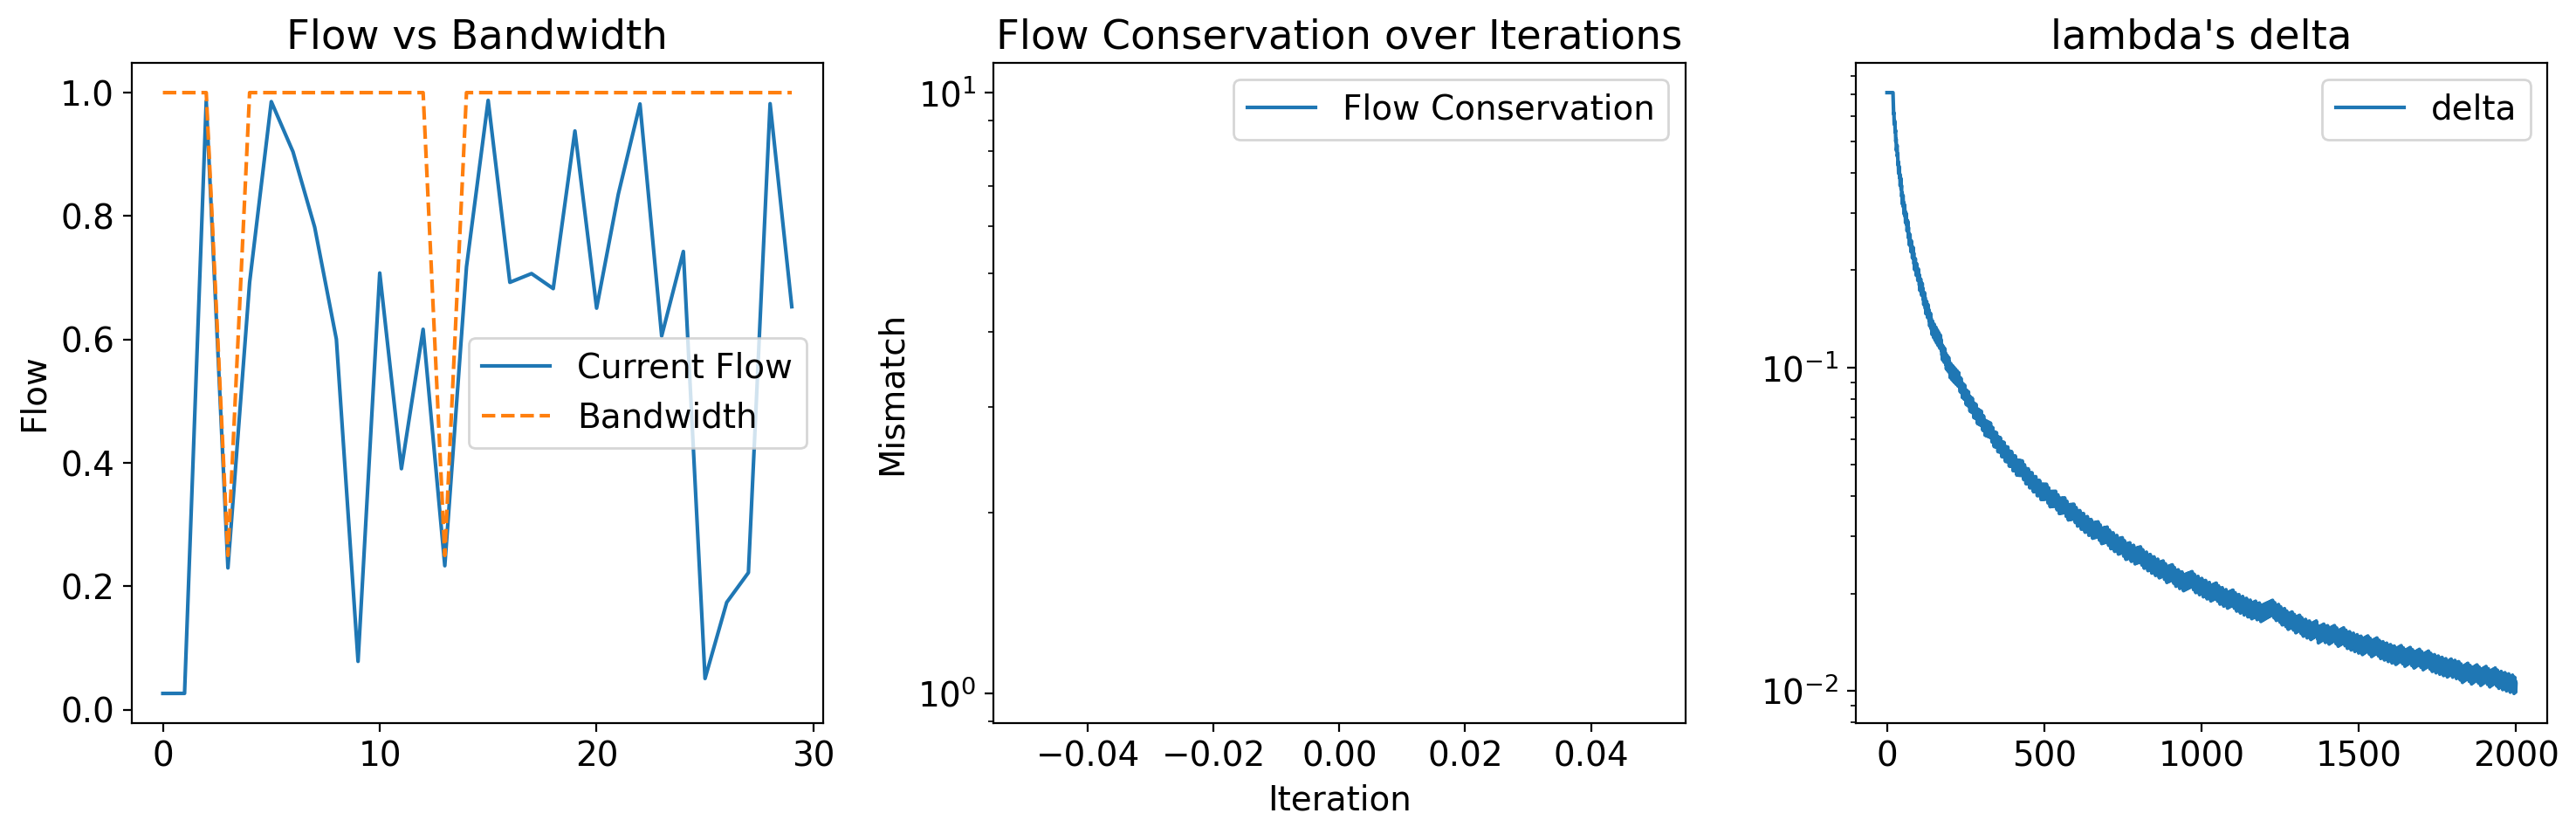

 40%|███▉      | 3957/10000 [00:07<00:07, 777.09it/s]

0.7040034071550255


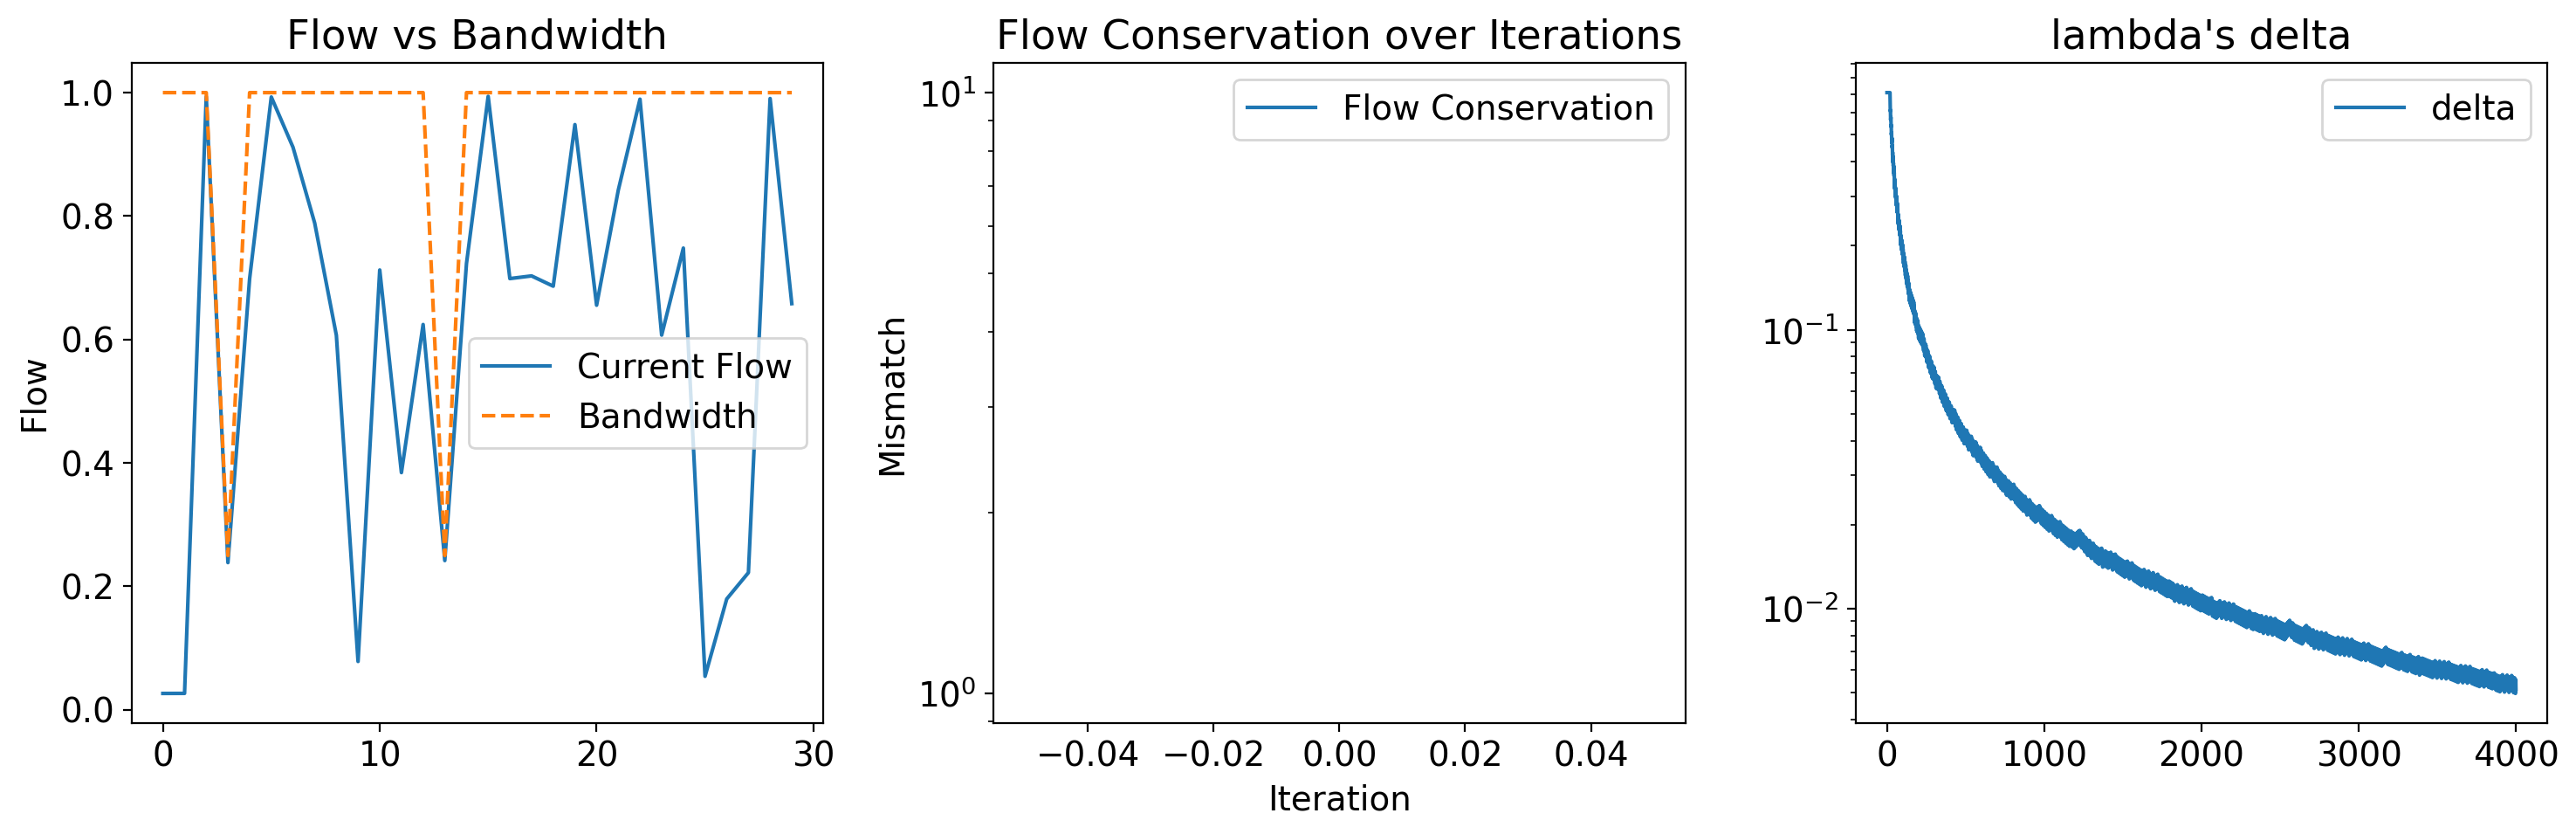

 60%|█████▉    | 5970/10000 [00:10<00:05, 738.43it/s]

0.7057987492893689


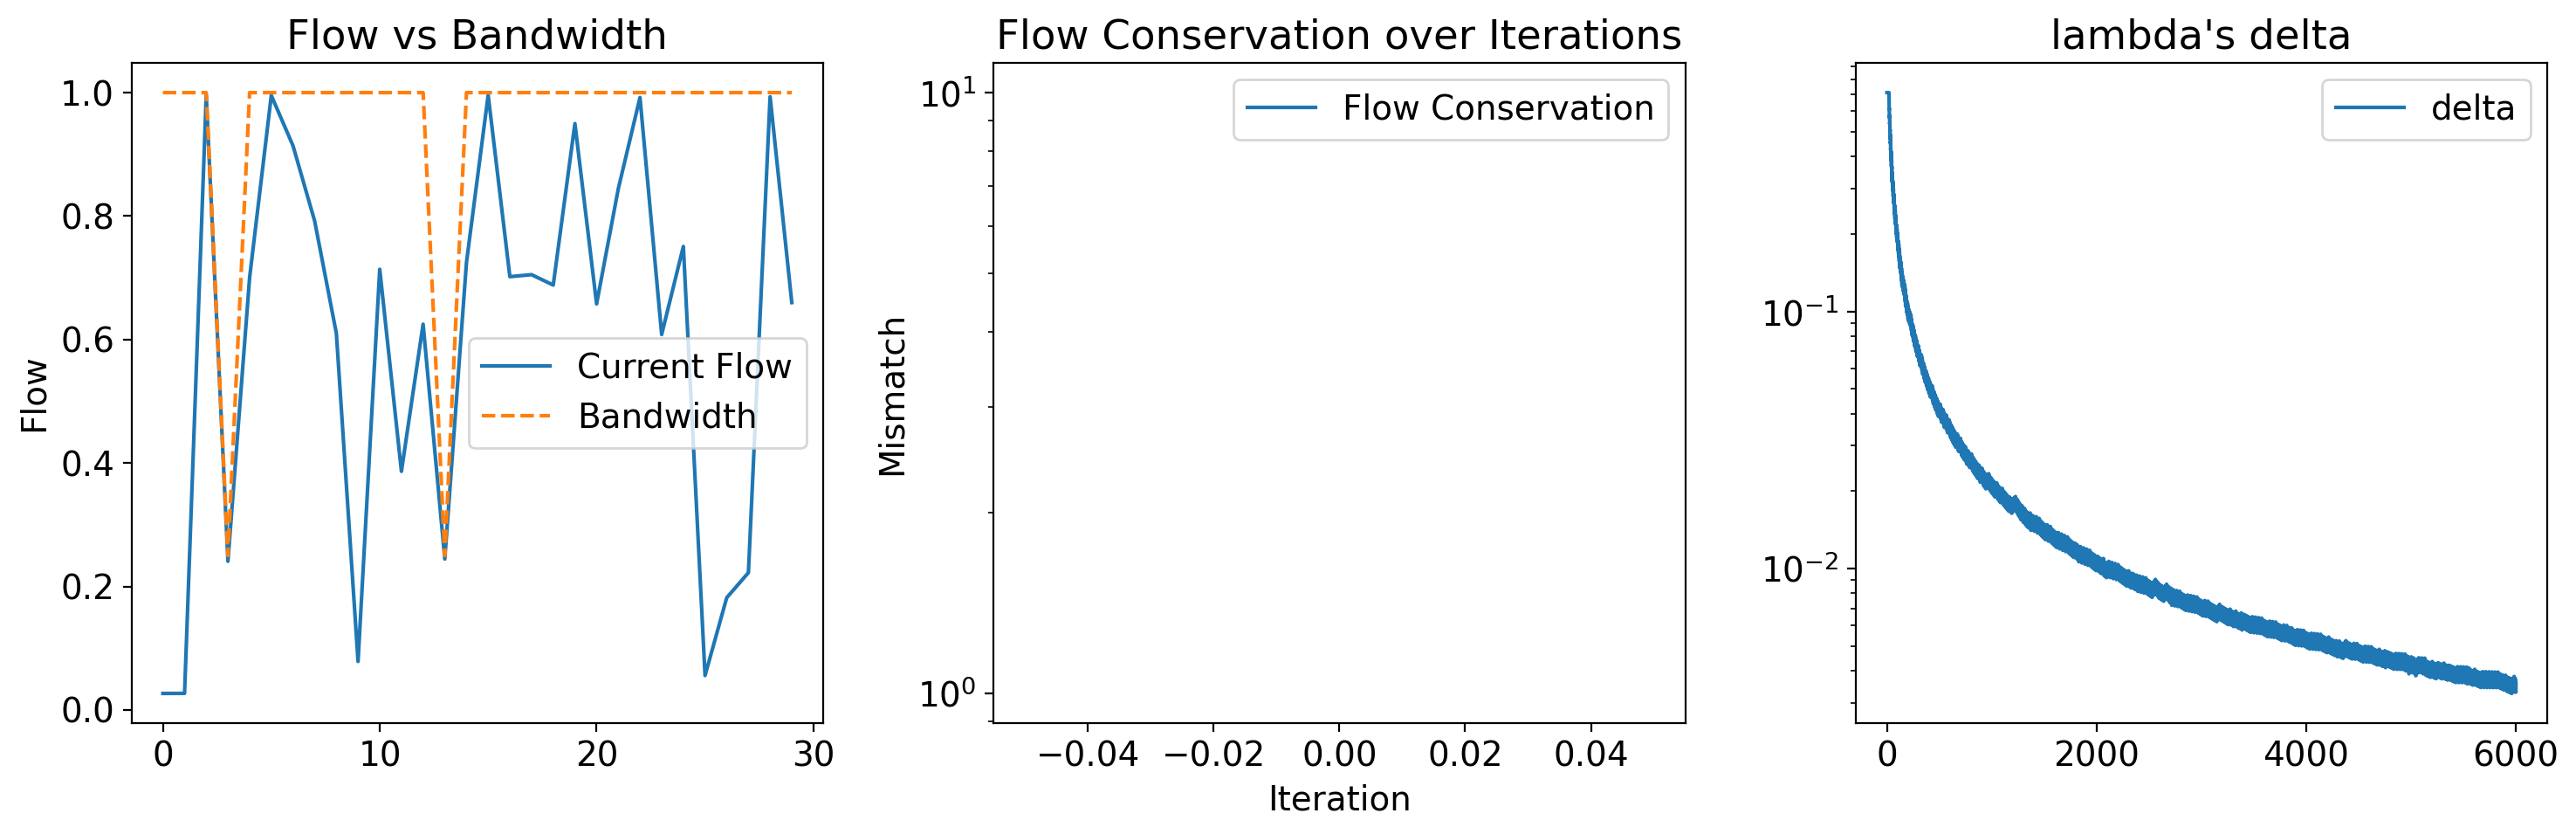

 80%|███████▉  | 7952/10000 [00:13<00:02, 765.08it/s]

0.7063339731285989


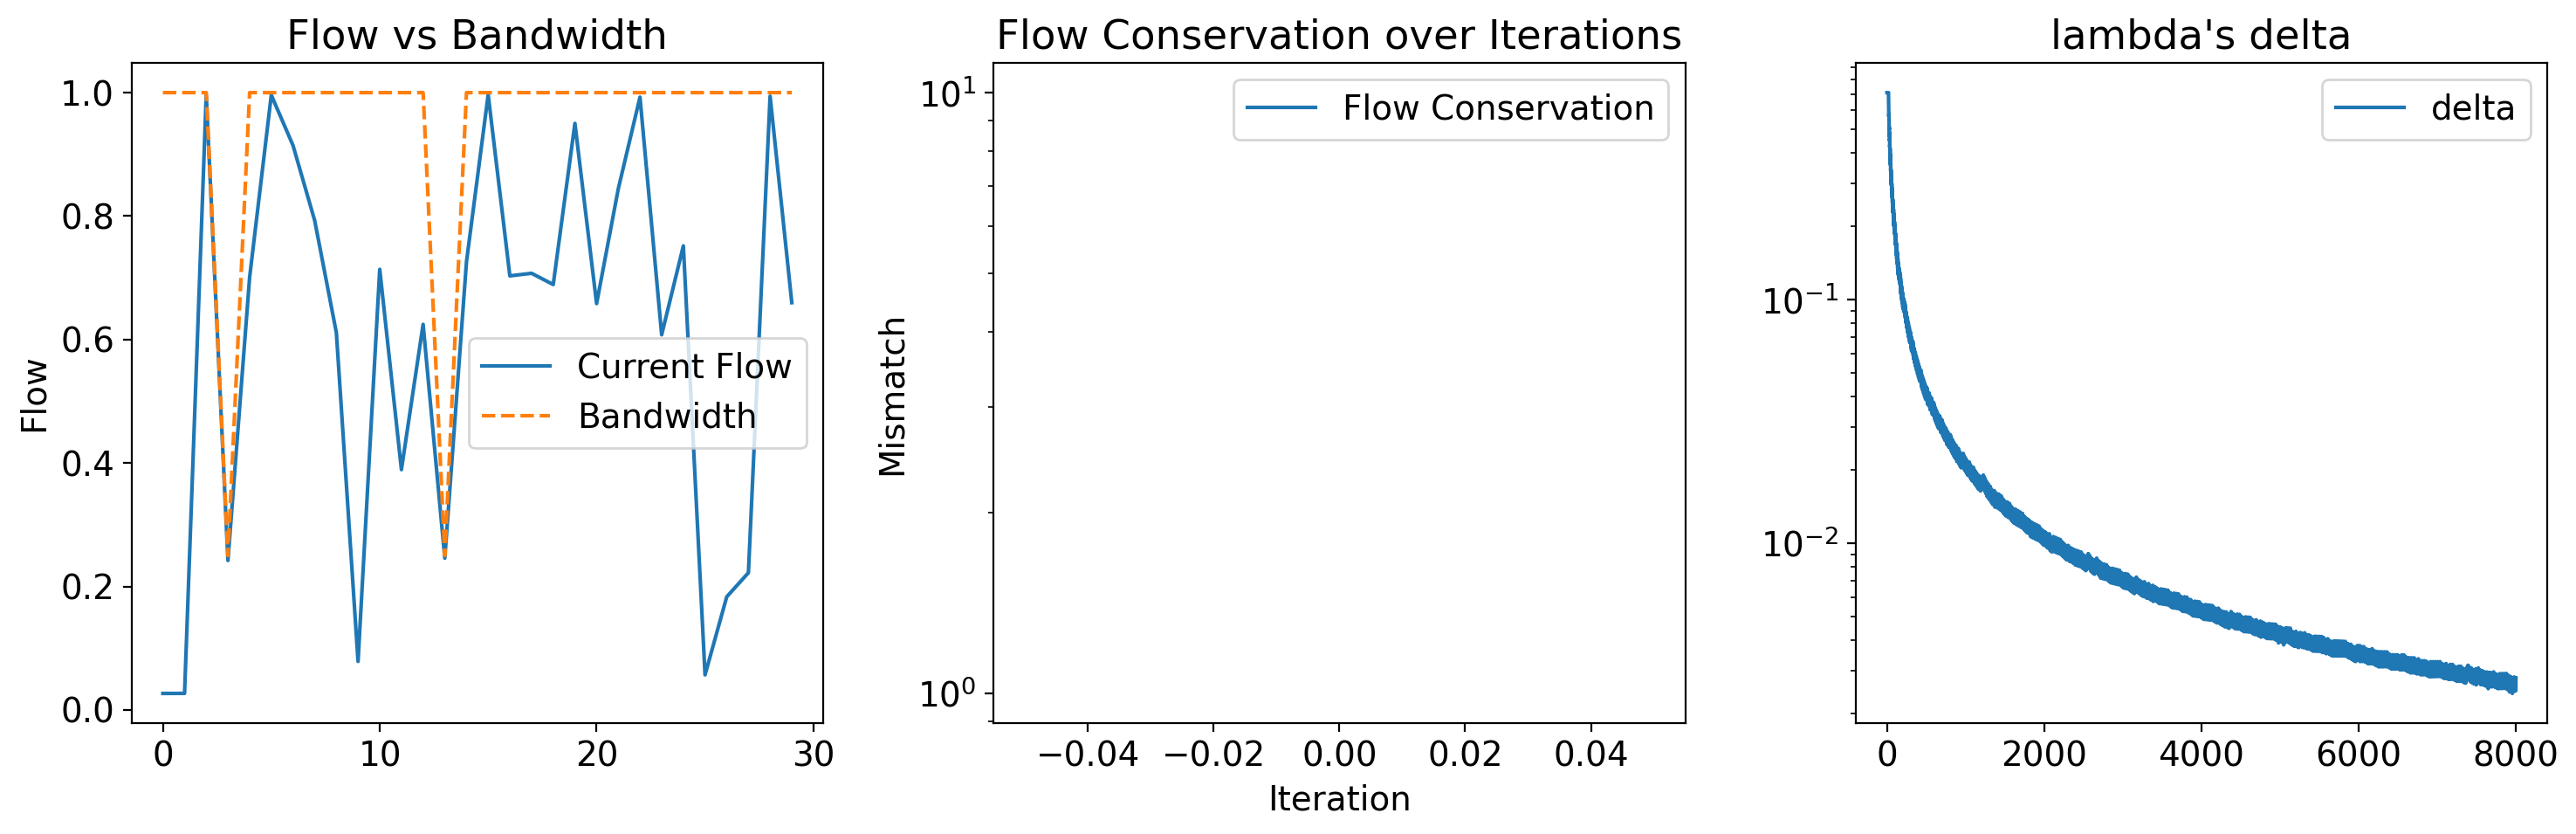

100%|██████████| 10000/10000 [00:17<00:00, 586.96it/s]


In [9]:
lambda_averaged, flows_averaged, lam_delta = no_potentials_switching(
    graph,
    traffic_mat,
    max_iters=10000,
    h_f=5e-2, 
    h_g=5e-2,
    epsilon=5e-2,
    throughput=lam,
    verbose=True,
)


In [10]:
df["no potentials"] = np.nan

lam_delta = [float(i) for i in lam_delta]

for i, value in enumerate(lam_delta):
    df.at[i, "no potentials"] = value

print(df.head())

   switching  regularization  no potentials
0    1.29087     1999.290870        0.70913
1    1.29087      999.290870        0.70913
2    1.29087      665.957536        0.70913
3    1.29087      499.290870        0.70913
4    2.29087      399.290870        0.70913


## Bounded $\Lambda$

/home/demyan/reps/optima_path_based/main.py:211: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_weighted = nx.incidence_matrix(
/home/demyan/reps/optima_path_based/utils.py:40: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)


0.9558446290546231


 19%|█▉        | 1934/10000 [00:02<00:11, 725.88it/s]

0.7097146370730328


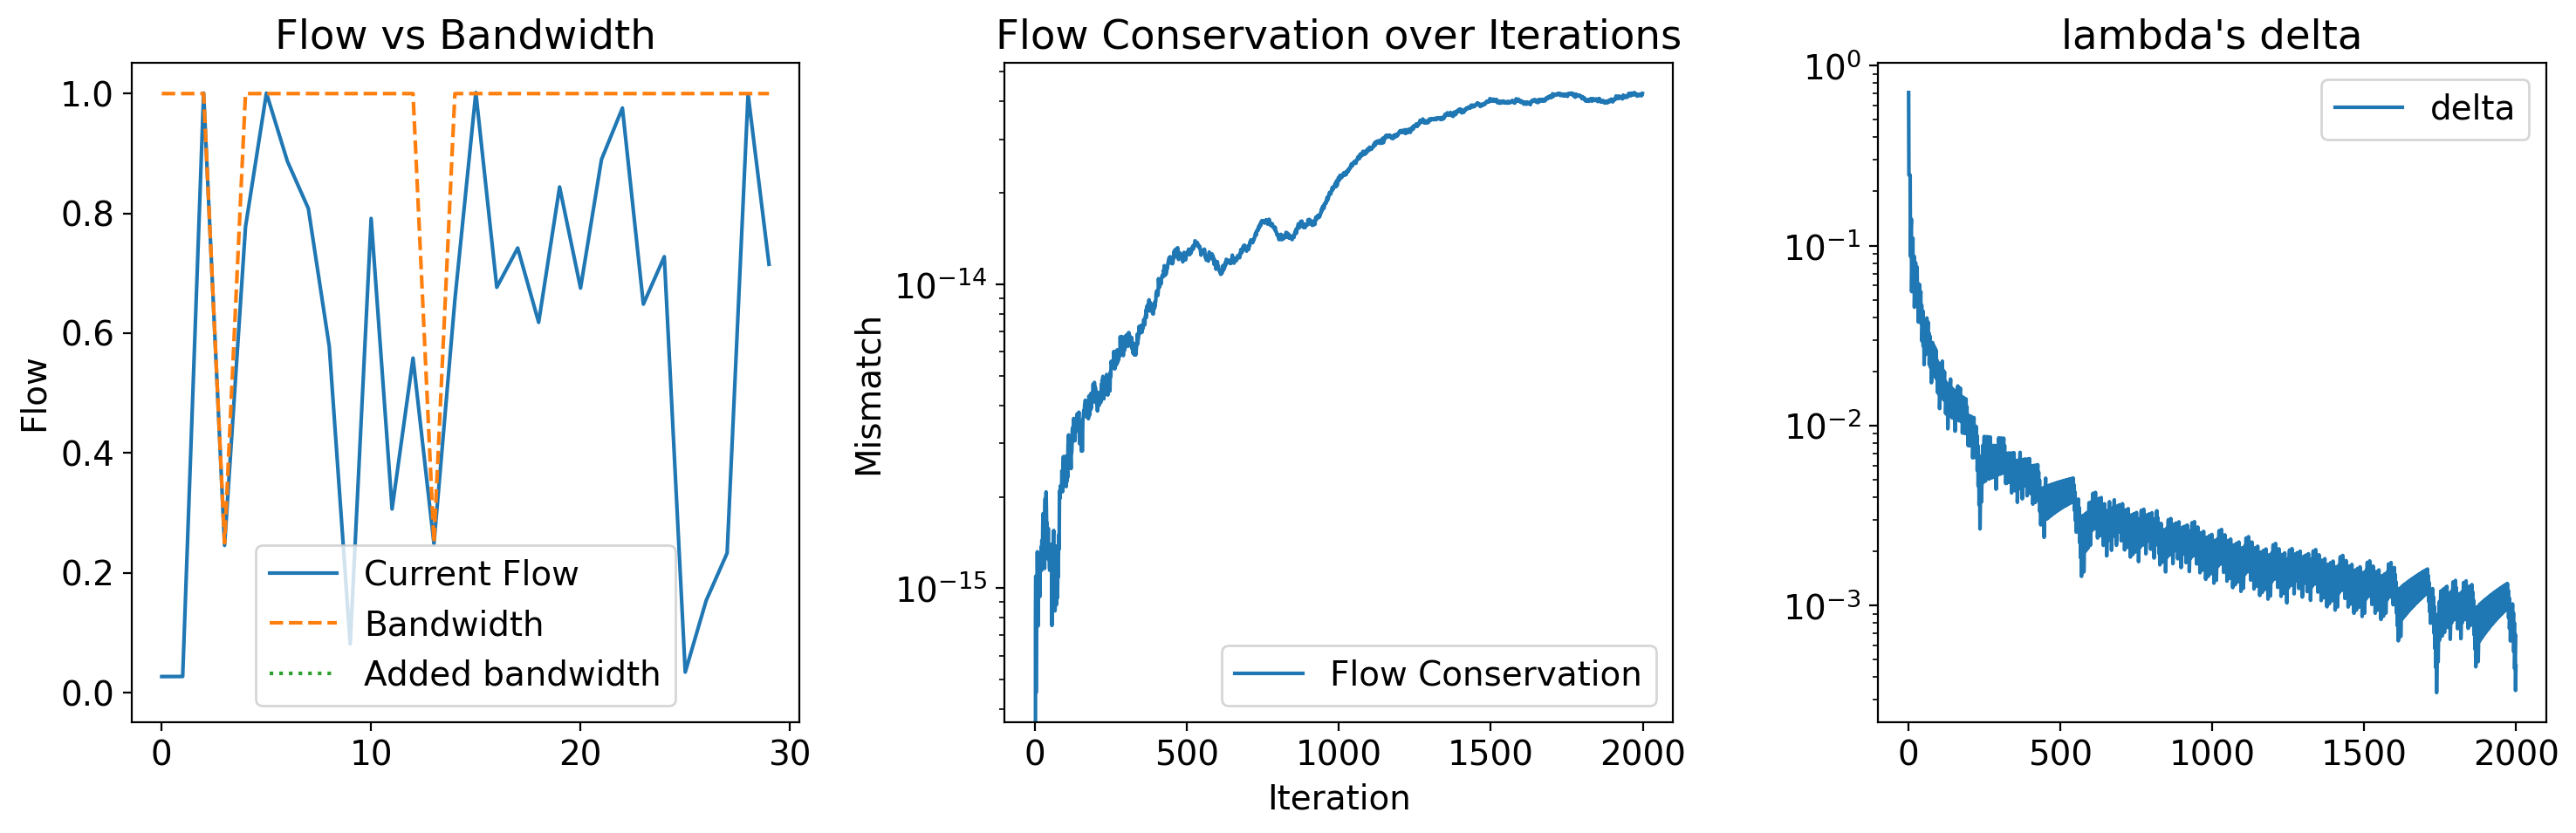

 40%|████      | 4000/10000 [00:06<00:08, 738.17it/s]

0.709475675915739


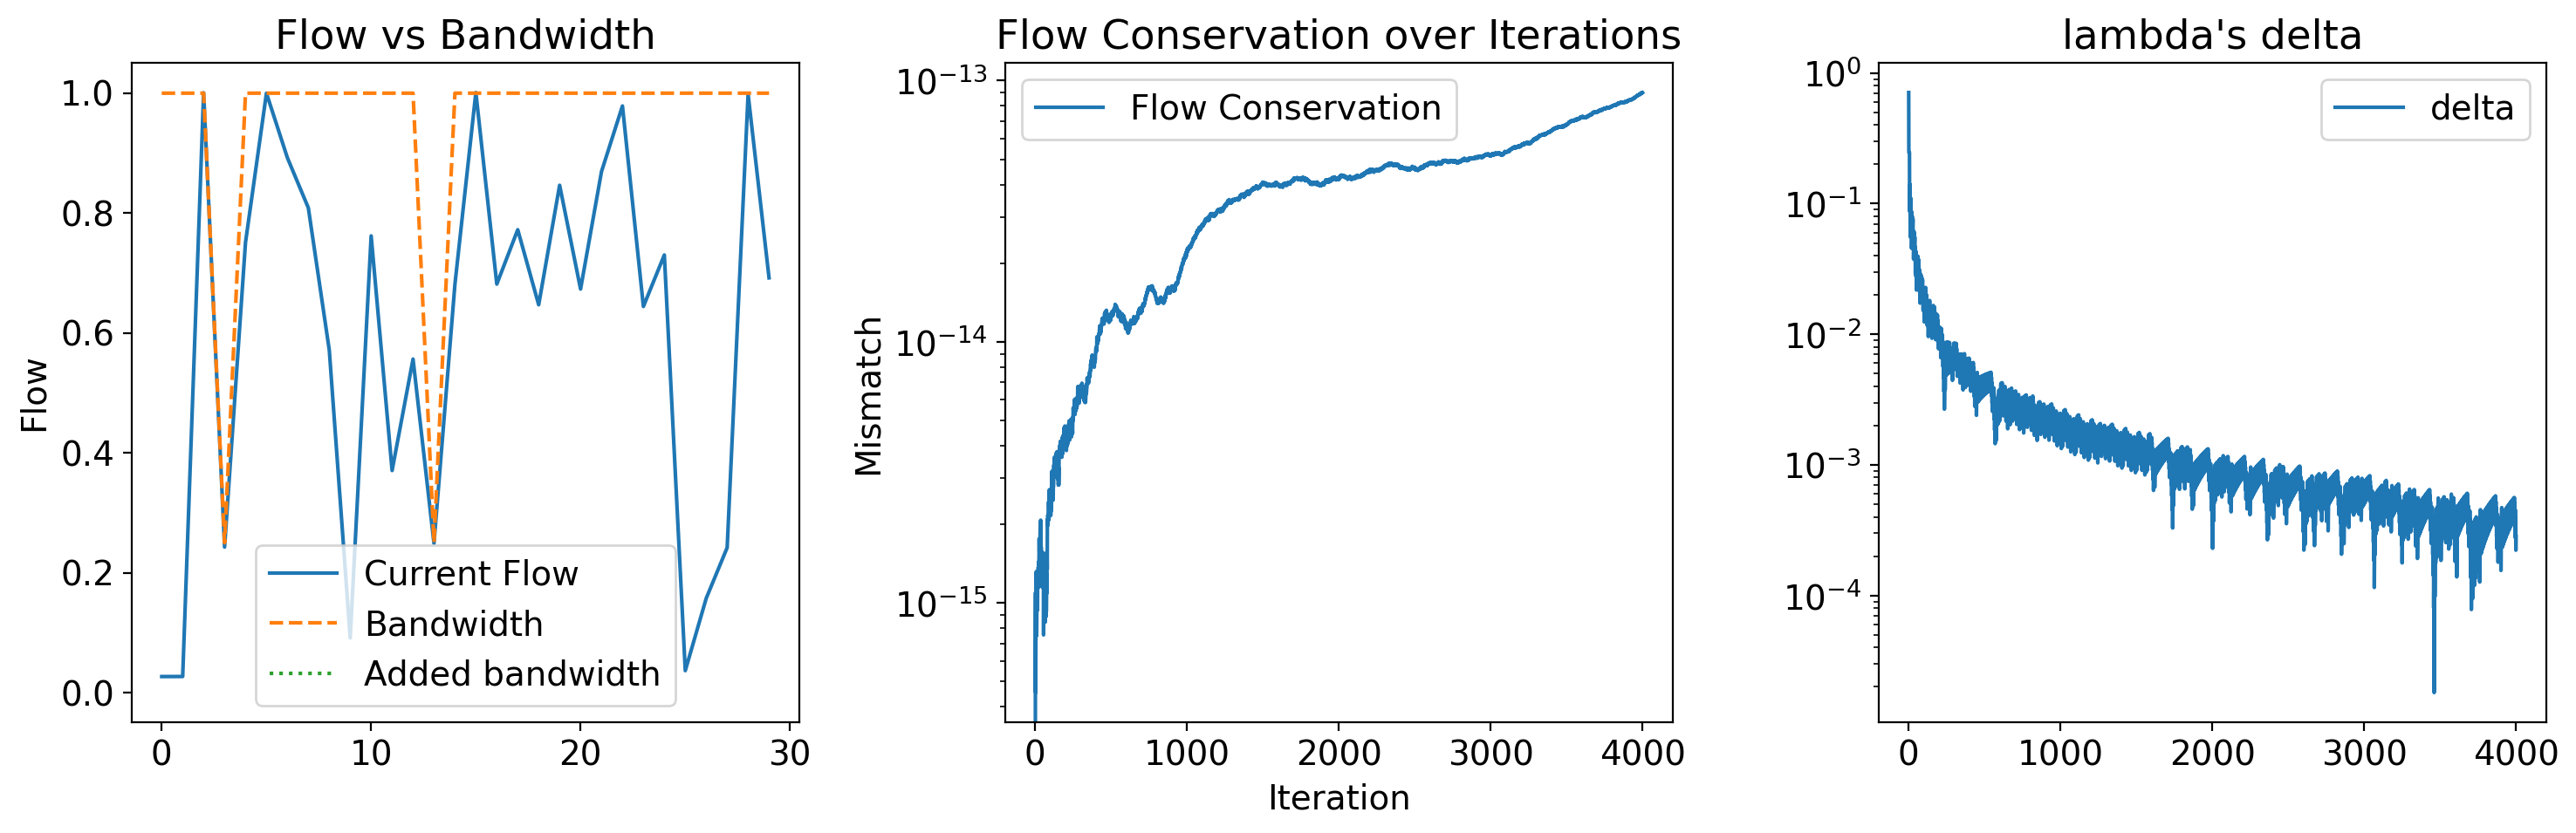

 59%|█████▉    | 5937/10000 [00:09<00:05, 739.07it/s]

0.7092367147584631


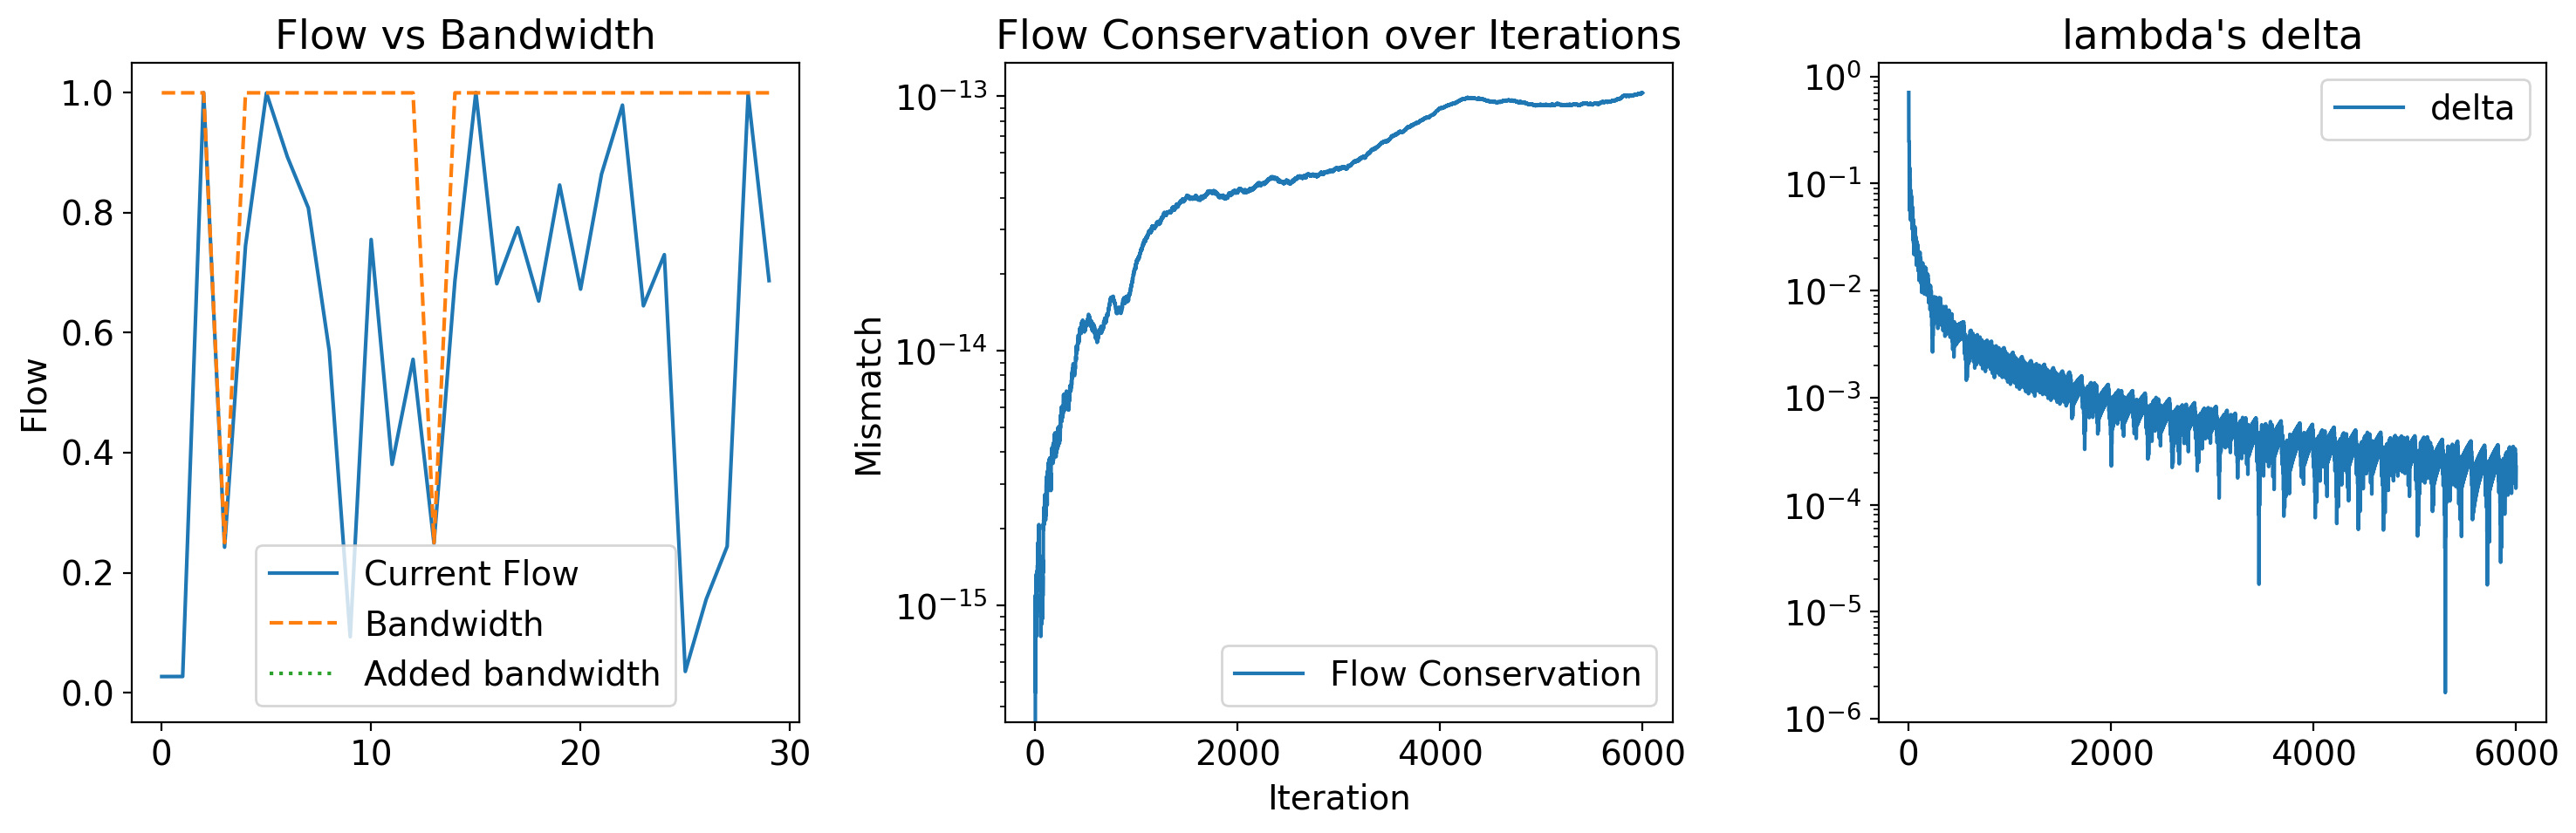

 80%|███████▉  | 7979/10000 [00:13<00:02, 730.78it/s]

0.7092367147584585


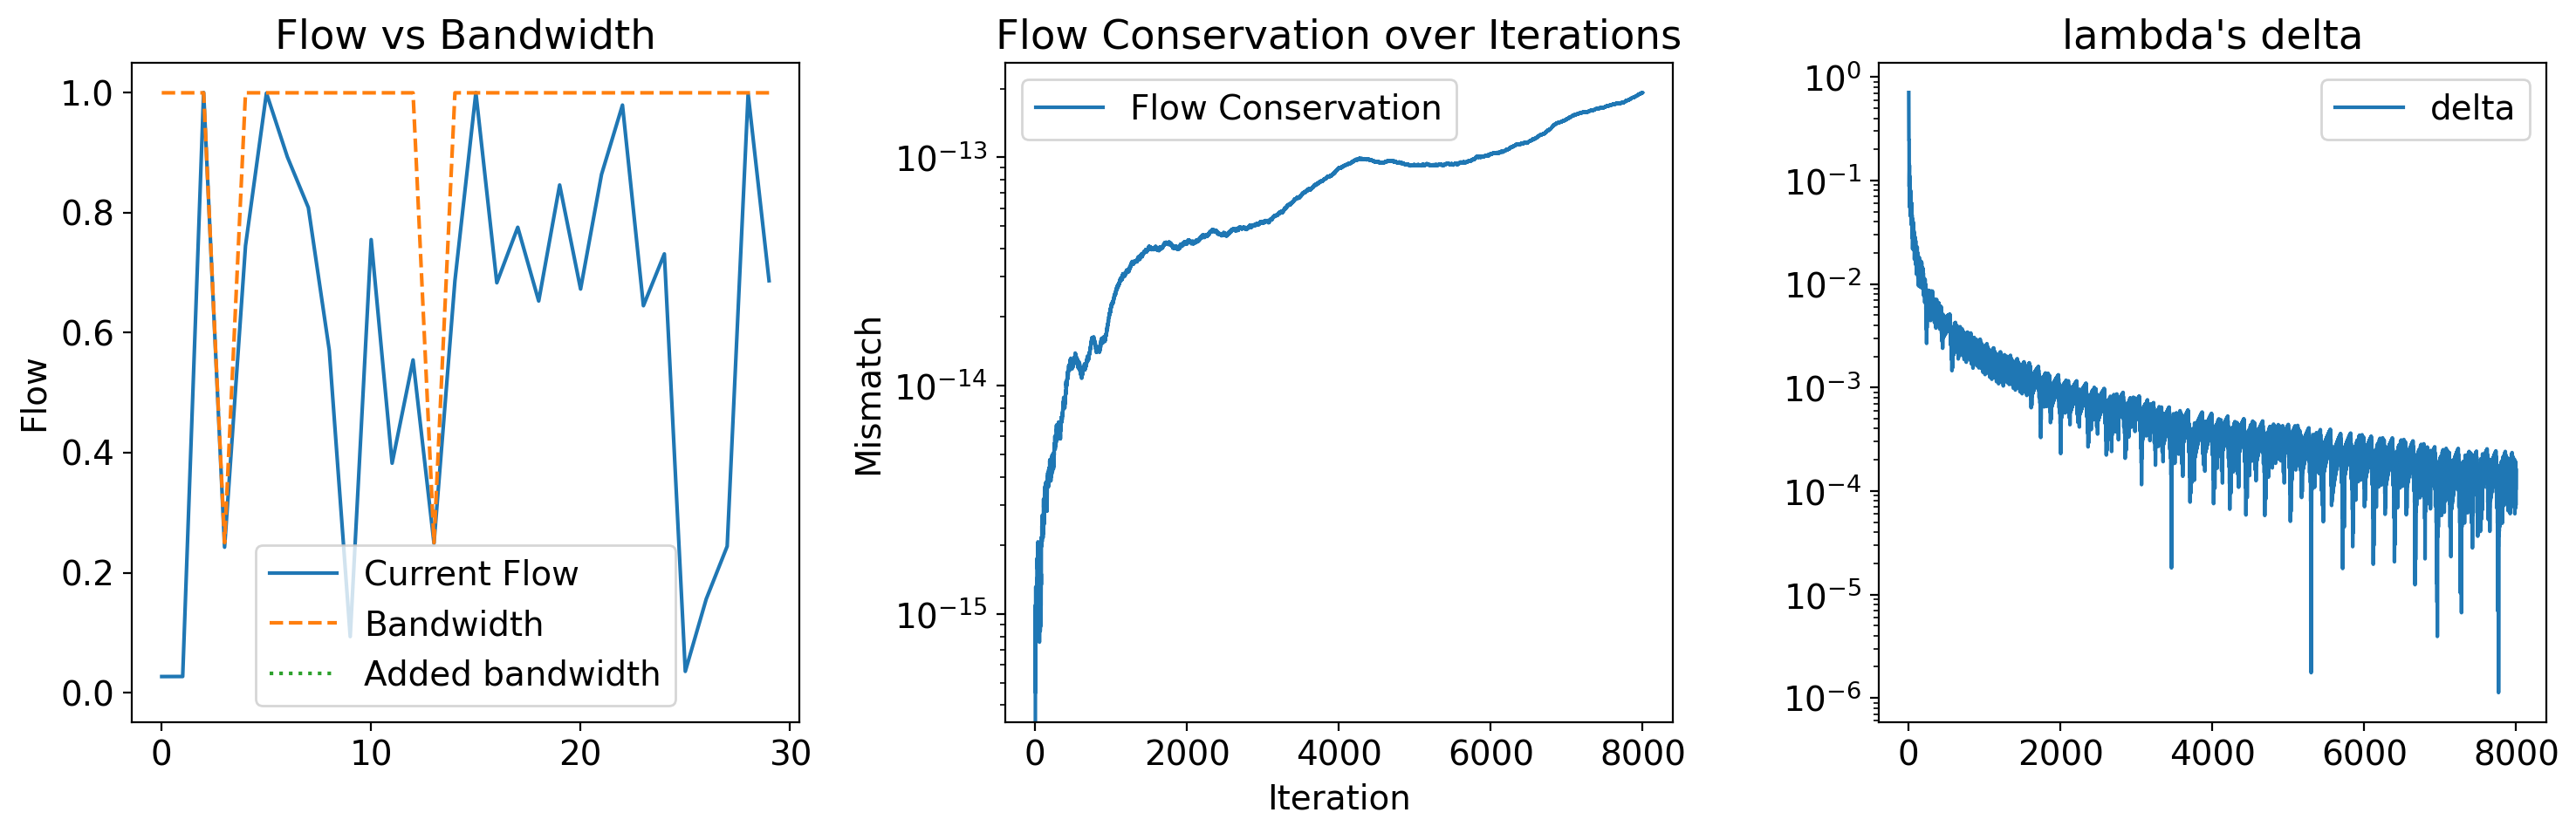

100%|██████████| 10000/10000 [00:17<00:00, 588.19it/s]


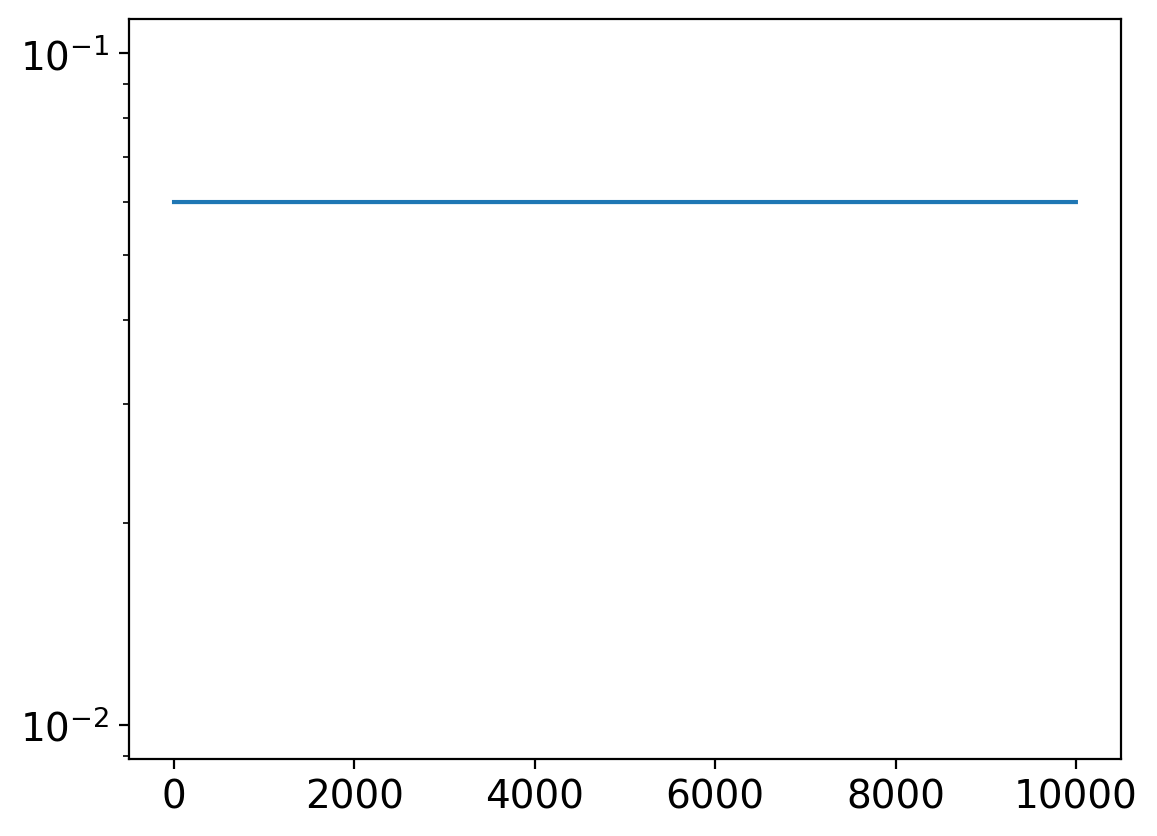

In [11]:
lambda_averaged, flows_averaged, lam_delta = bounded_ugd(
    graph,
    traffic_mat,
    max_iters=10000,
    h0=6e-2, 
    eps=None,
    throughput=lam,
    verbose=True,
)

In [12]:
df["bounded_Lambda"] = np.nan

lam_delta = [float(i) for i in lam_delta]

for i, value in enumerate(lam_delta):
    df.at[i, "bounded_Lambda"] = value


print(df.head())

   switching  regularization  no potentials  bounded_Lambda
0    1.29087     1999.290870        0.70913        0.709130
1    1.29087      999.290870        0.70913        0.246714
2    1.29087      665.957536        0.70913        0.246714
3    1.29087      499.290870        0.70913        0.246714
4    2.29087      399.290870        0.70913        0.246714


In [13]:
df_chart = pd.DataFrame(data)

df.to_csv("chart_data_abilene.csv", index=False)
#     df_chart = pd.read_csv("chart_data_abilene.csv")


In [14]:
df_chart = pd.read_csv("chart_data_abilene.csv")


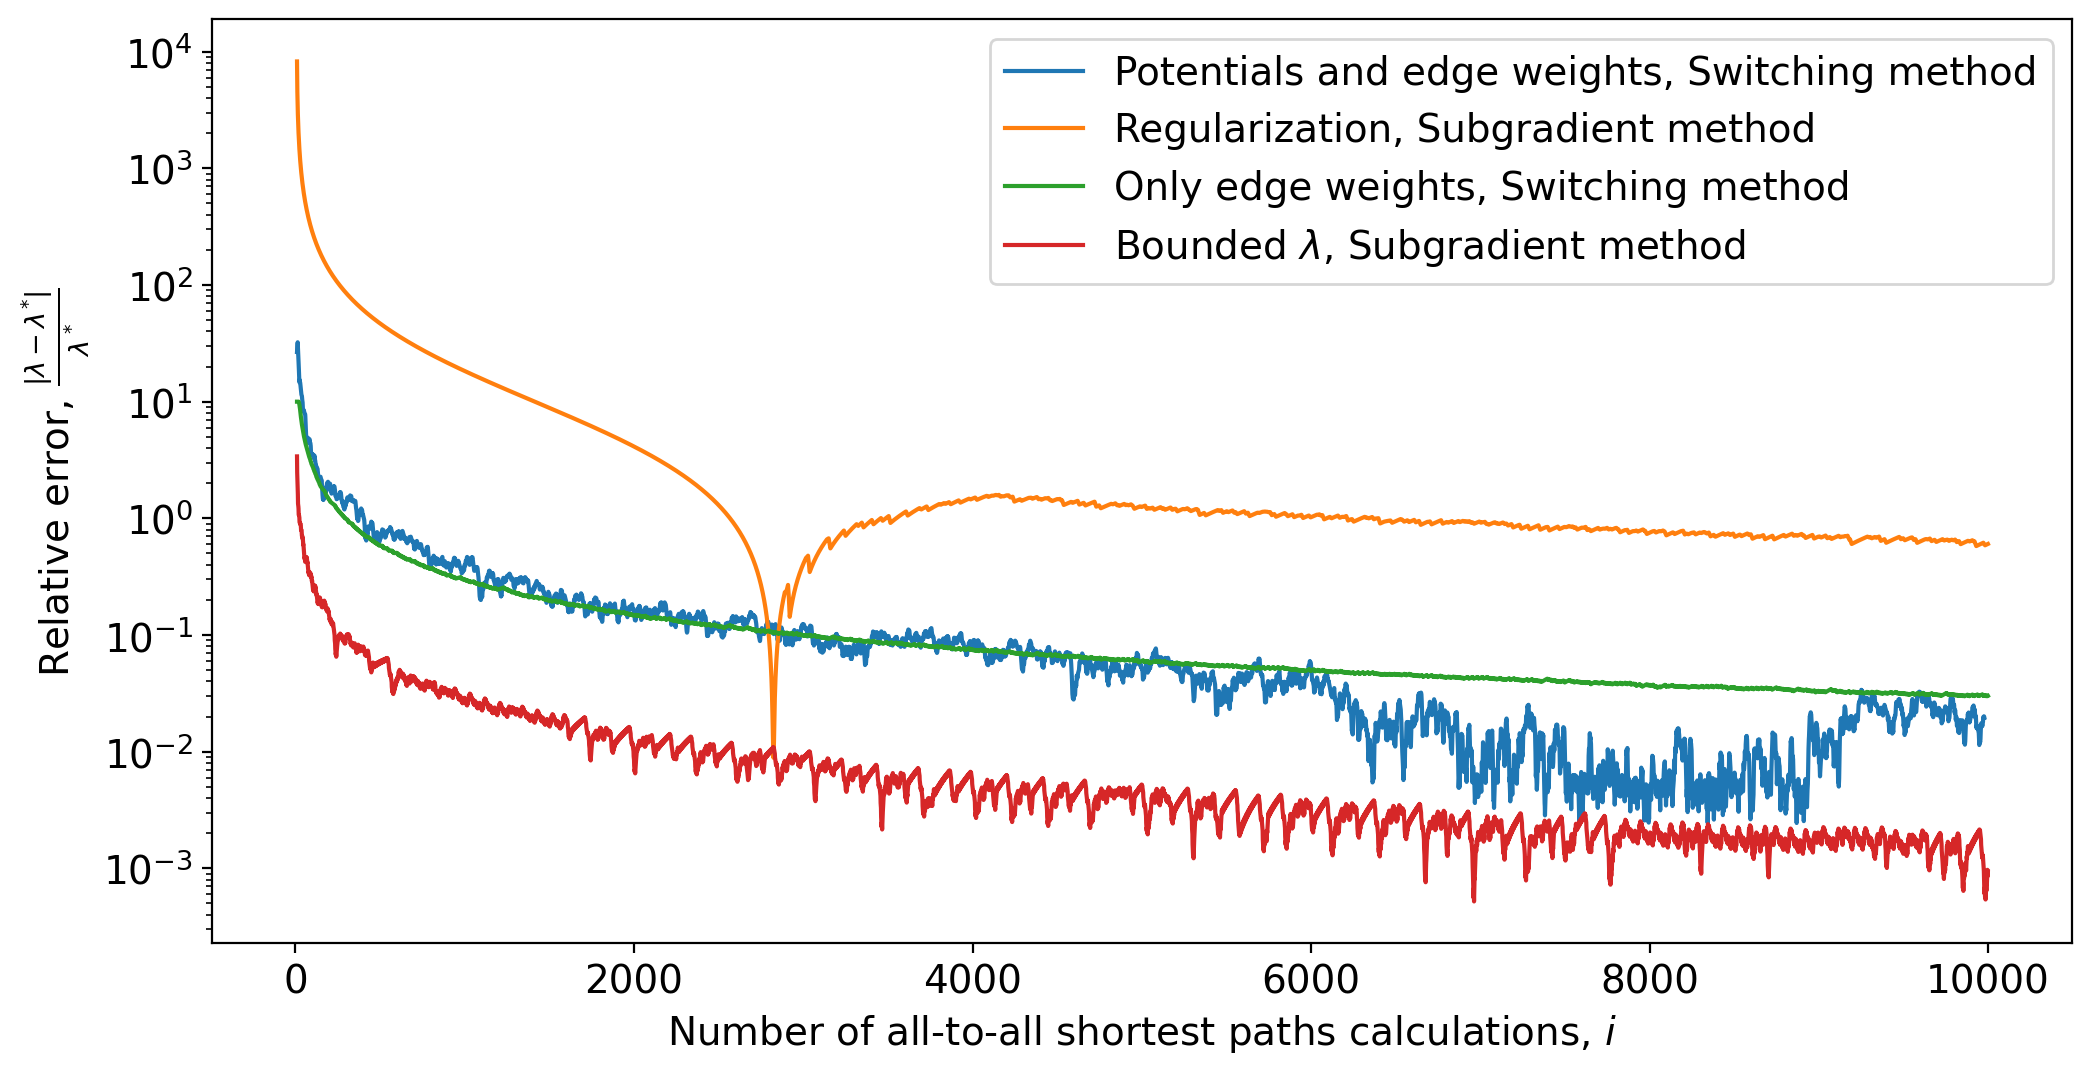

<Figure size 640x480 with 0 Axes>

In [15]:
import plotly.graph_objects as go

sampled_df = df_chart.rolling(window=10).sum()

sampled_df = sampled_df.rename(columns={
    "switching": "Potentials and edge weights, Switching method",
    "no potentials": "Only edge weights, Switching method",
    "regularization": "Regularization, Subgradient method",
    "bounded_Lambda": r"Bounded $\lambda$, Subgradient method",
})

f = plt.figure(figsize=(12, 6))

for column in sampled_df.columns:
    plt.plot(sampled_df.index, sampled_df[column] / lam, label=column)

plt.yscale("log")
plt.xlabel("Number of all-to-all shortest paths calculations, $i$")
plt.ylabel(r"Relative error, $\frac{|\lambda - \lambda^{*}|}{\lambda^*}$")
plt.legend()
plt.show()

plt.savefig("chart_data_abilene.pdf", bbox_inches="tight")


# Robust 

In [ ]:
from src.solvers.throughput.throughput import optimize_robust_throughput

solution = optimize_robust_throughput(graph, traffic_mat, solver=cp.SCIPY, budget=1, proportion_edge_perturbed=0.0)
print(solution.gamma)
robust_lam = solution.gamma


In [ ]:
lambda_averaged, flows_averaged, add_bw_averaged, lam_delta, (z_ij, y_e, t) = budget_switching(
    graph,
    traffic_mat,
    max_iters=5000,
    h_f=1e-2, 
    h_g=1e-2,
    epsilon=1e-3,
    throughput=robust_lam,
    budget=1,
    verbose=True,
#     start_point=start_point,
)
start_point = (z_ij, y_e, t)

In [ ]:
y_qe = None
lambda_averaged, flows_averaged, add_bw_averaged, lam_delta, y_qe = bounded_robust_gd(
    graph,
    traffic_mat,
    max_iters=10000,
    h0=7e-4,
    eps=None,
    throughput=robust_lam,
    budget=1,
    proportion_edge_perturbed=0.0,
    verbose=True,
#         y_qe0 = y_qe,
)

In [ ]:
solution = optimize_robust_throughput(graph, traffic_mat, solver=cp.SCIPY, budget=1, proportion_edge_perturbed=0.0)
print(solution.gamma)
robust_lam = solution.gamma


In [ ]:
lambda_averaged, flows_averaged, add_bw_averaged, lam_delta, (z_qij, y_qe, t) = robust_switching(
    graph,
    traffic_mat,
    max_iters=5000,
    h_f=1e-2, 
    h_g=1e-2,
    epsilon=1e-3,
    throughput=robust_lam,
    budget=1,
    proportion_edge_perturbed=0.9,
    verbose=True,
#     start_point=start_point,
)
start_point = (z_qij, y_qe, t)

In [ ]:
y_qe = None 
lam_deltas = []
for max_iters, h in [[3000, 7e-4], [7000, 5e-5]]:
    lambda_averaged, flows_averaged, add_bw_averaged, lam_delta, y_qe = bounded_robust_gd(
        graph,
        traffic_mat,
        max_iters=max_iters,
        h0=h,
#         h0=1e-5,
        eps=None,
        throughput=robust_lam,
        budget=1,
        proportion_edge_perturbed=0.9,
        verbose=True,
        y_qe0 = y_qe,
    )
    lam_deltas.append([float(x) for x in lam_delta])
    

with open("abilene_robust_gd.json", "w") as fp:
    json.dump(lam_deltas, fp)

In [ ]:
with open("abilene_robust_gd.json", "r") as fp:
    lam_deltas = json.load(fp)
    
plt.plot(np.array(sum(lam_deltas, [])) / robust_lam)
plt.yscale("log")

In [ ]:
plt.plot(y_qe.sum(axis=0) * 2, label="y")
plt.plot(add_bw_averaged, label="add bw")
plt.plot(bandwidths.a, label="bw")
plt.plot(flows_averaged[0], label="flow")
plt.legend()